# Tesla Stock Sentiment Analysis Project


1. Overview of the Approach

This project investigates the manner in which news media represent and contextualize Tesla and Elon Musk throughout the year 2025.
GDELT records are used, and these records contain extracted entities, tone scores, themes, geographical references, and article metadata.

The study is guided by several goals:

Entities mentioned within articles are extracted and structured.

Entity co occurrence networks are constructed so that concepts that frequently appear together can be revealed.

Sentiment is computed at the article level or the sentence level so that relations between entity pairs can be characterized.

Topics are modeled by means of BERTopic so that latent themes can be identified.

Temporal patterns are analyzed, including the volume of news coverage and the evolution of sentiment.

The networks, relationships, time series and cluster structures are visualized.

All steps are carried out within a reproducible pipeline, and the results can be regenerated when the notebook is executed again.

#Part A – Data & Networks


## 1. Setup and Imports

In this section the libraries that are required throughout the notebook are imported. Pandas and numpy are used for data manipulation and numerical operations. Matplotlib is used for visualization. The scikit learn tools are used for the extraction of n gram features and for the encoding of categorical variables. The BERTopic library is imported so that topic modelling can be performed. The nltk tools are imported so that sentiment scoring and stop word removal can be carried out. NetworkX is imported so that graphs can be created and visualized. A simple visual style is applied to all plots.

In [1]:
# Required libraries are installed and imported for use throughout the notebook.

%pip install -U bertopic[all]

import pandas as pd   # Used for data loading and manipulation
import numpy as np    # Used for numerical operations
import matplotlib.pyplot as plt  # Used for data visualization
import networkx as nx
import ast

import re  # Used for text cleaning with regular expressions
from nltk.corpus import stopwords  # Used for removing stop words
from nltk.sentiment.vader import SentimentIntensityAnalyzer  # Used for sentiment scoring

from sklearn.feature_extraction.text import CountVectorizer  # Used to extract n-gram features
from sklearn.preprocessing import LabelEncoder  # Used to encode categorical variables

from bertopic import BERTopic  # Used for topic modelling

import networkx as nx  # Used for constructing and visualizing graphs

# A simple visual style is applied to all plots.
plt.style.use('ggplot')


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 153.0/153.0 kB 4.9 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/hdbscan/robust_single_linkage_.py:175: SyntaxWarning: invalid escape sequence '\{'
  $max \{ core_k(a), core_k(b), 1/\alpha d(a,b) \}$.


##2. Data Loading

In this section the news articles related to Tesla and Elon Musk are loaded. The datasets that were previously produced in GDELT format are accessed from the project directory in Google Drive after the drive has been mounted. The file paths for the Tesla and Elon datasets are defined and the corresponding comma separated value files are read into memory. The SQLDATE column in each dataset is converted into a valid date format so that the data can be used in subsequent temporal analysis. Rows that do not contain a valid date are removed. The datasets are then restricted to articles that were published during the year two thousand twenty five. A short preview of each dataset is displayed so that the structure of the data can be inspected.

In [2]:
from pathlib import Path
import os
from google.colab import drive

# Google Drive is mounted so that project files can be accessed.
drive.mount('/content/drive')

# The directory containing all datasets is specified.
BASE_DIR = Path("/content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared")

print("Directory contents:")
print(os.listdir(BASE_DIR))

# Filenames for Tesla and Elon datasets are defined.
TESLA_FILENAME = "tesla_gdelt_2025_revised.csv"
ELON_FILENAME  = "elon_related_2025.csv"

# Complete paths to the datasets are constructed.
tesla_path = BASE_DIR / TESLA_FILENAME
elon_path  = BASE_DIR / ELON_FILENAME

# The datasets are loaded into memory.
tesla_full = pd.read_csv(tesla_path)
elon_full  = pd.read_csv(elon_path)

# SQLDATE is converted into a valid datetime format.
for df in (tesla_full, elon_full):
    df["SQLDATE"] = pd.to_datetime(
        df["SQLDATE"].astype(str),
        format="%Y%m%d",
        errors="coerce"
    )
    df.dropna(subset=["SQLDATE"], inplace=True)

# Data is filtered so that only articles published in 2025 are included.
tesla_df = tesla_full[tesla_full["SQLDATE"].dt.year == 2025].copy()
elon_df  = elon_full[elon_full["SQLDATE"].dt.year == 2025].copy()

print("Tesla 2025 range:", tesla_df["SQLDATE"].min(), "to", tesla_df["SQLDATE"].max())
print("Elon  2025 range:", elon_df["SQLDATE"].min(), "to", elon_df["SQLDATE"].max())

# A preview of each dataset is displayed.
print("Tesla preview:")
print(tesla_df.head())

print("Elon preview:")
print(elon_df.head())

Mounted at /content/drive
Directory contents:
['tesla_gdelt_2025_revised (1).csv', 'entities.ipynb', 'tesla_gdelt_2025 (1).csv', 'graphs_out', 'edges_all.csv', 'failed_urls.csv', 'url_metadata.csv', 'entities_summary.csv', 'graphs_out.zip', 'articles_by_day', 'articles_2025_by_day', 'tesla_gdelt_full.csv', 'elon_related_full.csv', 'articles_index_2025.csv', 'pair_counts_2025_by_day', 'entities_per_url_original.csv', 'entities_per_url.csv', 'pair_counts_2025_cumulative.csv', 'edges_with_sentiment_2025_cumulative_q75.csv', 'entities_clustered_BACKUP.csv', 'texts', 'cache_sent', 'entities_prework (1).ipynb', 'df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv', 'entities_pair 1.ipynb', 'NLP_project_initialwork_2_0 (1).ipynb', 'entity_pairs_results.csv', 'top_pairs_75th_quantile_by_day (1).csv', 'FINAL (5).ipynb', 'tesla FINAL.ipynb', 'tesla_gdelt_2025_revised.csv', 'elon_related_2025.csv', 'articles_with_text_and_metadata.parquet', 'articles_with_text_only.parquet', 'Dataset_Loader_and_E

##3. Important Note About Execution

The operations that are carried out up to the stage where entity pairs and sentiment scores are produced are very computationally intensive. These operations involve the processing of thousands of articles, the extraction of entities by means of spaCy, the clustering of similar entities by the use of sentence embeddings, and the computation of VADER sentiment scores for all sentences in which those entities appear. These steps have already been executed in the original project notebooks. They should not be executed again unless the regeneration of the intermediate files is required. The outputs that were previously saved, including the files named entities_per_url.csv, final_filtered_df.csv, entities_clustered_BACKUP.csv and entity_pairs_results.csv, should therefore be reused.

## 4. Visualising Article Volume

In this section the volume of news coverage is examined before sentiment analysis is introduced. The Tesla and Elon datasets are combined so that the number of articles published each day can be viewed within a single table. A count of unique article addresses is computed for each day so that repeated references to the same source address are not counted more than once. The data are then reshaped into a daily table in which dates form the index and article counts for Tesla and Elon are recorded in separate columns. A continuous sequence of dates is created so that days without published articles are represented by zeros. The resulting daily series is plotted, and the figure reveals fluctuations in news activity. Peaks in the observed volume often coincide with major events.

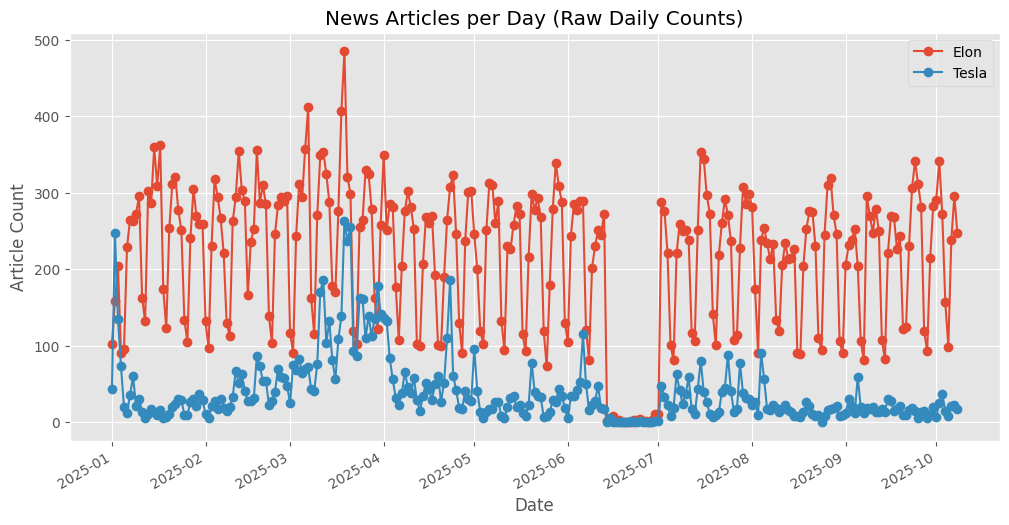

In [3]:
# The two datasets are combined so that article volume for Tesla and Elon
# can be examined within a single DataFrame.
combined_df = pd.concat(
    [
        tesla_df.assign(type="Tesla"),  # A label is attached to Tesla articles
        elon_df.assign(type="Elon")     # A label is attached to Elon articles
    ],
    ignore_index=True
)

# The number of unique articles per day is counted separately for Tesla and Elon.
# SOURCEURL is used so that duplicate references to the same URL are not double-counted.
article_counts = (
    combined_df
    .groupby(["SQLDATE", "type"])["SOURCEURL"]
    .nunique()
    .reset_index(name="article_count")
    .sort_values("SQLDATE")           # Rows are ordered chronologically
)

# The data are reshaped to form a date × entity-type table.
daily = (
    article_counts
    .pivot(index="SQLDATE", columns="type", values="article_count")
    .fillna(0)                        # Missing combinations are treated as zero articles
    .sort_index()                     # Dates are ensured to be in order
)

# A continuous daily index is created so that days with no articles are shown as zeros.
full_index = pd.date_range(daily.index.min(), daily.index.max(), freq="D")
daily = daily.reindex(full_index, fill_value=0)
daily.index.name = "SQLDATE"

# The actual daily article counts are plotted for each type (no rolling average).
plt.figure(figsize=(12, 6))
plt.plot(daily.index, daily["Elon"], marker="o", linestyle="-", label="Elon")
plt.plot(daily.index, daily["Tesla"], marker="o", linestyle="-", label="Tesla")

plt.title("News Articles per Day (Raw Daily Counts)")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.legend()
plt.gcf().autofmt_xdate()  # Date labels are rotated for readability
plt.show()

The figure presents exact daily article counts for Tesla and Elon without the use of any smoothing procedure.
Each point is produced from the number of unique GDELT articles that appear on that date and satisfy the Tesla or Elon filters.
The red line for Elon and the blue line for Tesla appear jagged because all day to day variation is displayed directly.
Large values in the plot indicate days on which intense news activity is recorded, and low values, including days with a value of zero, represent periods with limited or no coverage.
When the two curves are compared, it can be observed that Elon Musk receives greater coverage on most days, although periods also appear in which news that concerns Tesla rises sharply, often during important product or market events.

The daily percentage change in the closing price of Tesla stock is computed and converted into qualitative movement labels.
Each day is classified as Positive, Negative or Neutral according to fixed percentage change thresholds.
This procedure is used to create a simple measure of market reaction that can be compared with the sentiment extracted from news articles.
The resulting labels serve as the outcome variable for later analysis and prediction.

In [4]:
import yfinance as yf

# Daily closing prices for Tesla are downloaded from Yahoo Finance.
ticker = "TSLA"
start_date = tesla_df["SQLDATE"].min() - pd.Timedelta(days=5)  # A few days are included before the news window
end_date   = tesla_df["SQLDATE"].max() + pd.Timedelta(days=5)  # A few days are included after the news window

stock_data = yf.download(ticker, start=start_date, end=end_date, progress=False)

# The percentage change in closing price from one day to the next is computed.
stock_data['pct_change'] = stock_data['Close'].pct_change() * 100

# The threshold is set to 2 percent in accordance with the notebook cum_graphs_NLP_1.ipynb.
threshold = 2.0

conditions = [
    stock_data['pct_change'] > threshold,    # price is increased by more than 2 percent
    stock_data['pct_change'] < -threshold    # price is decreased by more than 2 percent
]
choices = ['Positive', 'Negative']

# A Neutral label is assigned otherwise when the percentage change lies between minus 2 percent and plus 2 percent inclusive.
stock_data['label'] = np.select(conditions, choices, default='Neutral')


# A preview of the labelled stock data is displayed.
print(stock_data[["Close", "pct_change", "label"]].head())


Price            Close pct_change     label
Ticker            TSLA                     
Date                                       
2024-12-27  431.660004        NaN   Neutral
2024-12-30  417.410004  -3.301209  Negative
2024-12-31  403.839996  -3.251002  Negative
2025-01-02  379.279999  -6.081616  Negative
2025-01-03  410.440002   8.215567  Positive


In [5]:
stock_data["label"].value_counts()

,count
label,
Neutral,84
Positive,58
Negative,55


In [6]:
stock_data.shape[0]

197

##

## Relationship between Tesla news volume and stock movement

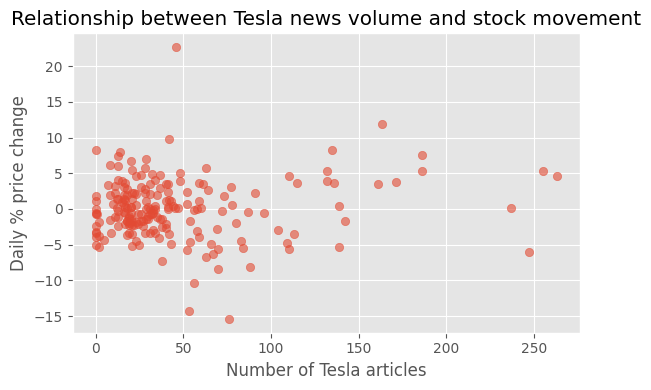

In [7]:
# Tesla article volume is aligned with stock trading days.
tesla_volume = daily["Tesla"].reindex(stock_data.index).fillna(0)

# Days with valid percentage changes are retained.
mask = stock_data["pct_change"].notna()
x = tesla_volume[mask]
y = stock_data.loc[mask, "pct_change"]

# A scatter plot that shows the relation between news volume and stock price change is produced.
plt.figure(figsize=(6, 4))
plt.scatter(x, y, alpha=0.6)
plt.xlabel("Number of Tesla articles")
plt.ylabel("Daily % price change")
plt.title("Relationship between Tesla news volume and stock movement")
plt.tight_layout()
plt.show()



## 6. Reading Article Texts and Merging with Dates

The raw article texts stored in the texts/ directory were joined with the GDELT-derived metadata using the TEXT_FILE identifier. Only filenames appearing in the mapping table were read from disk, in order to reduce I/O overhead and memory usage. The resulting articles_df dataset contains, for each article, its publication date (SQLDATE), source URL, and full text content, and is used for all subsequent text-based analyses (tokenisation, n-gram extraction, and topic modelling)



### Method

1. **Metadata loading**  
   The file `df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv` is imported.  
   It contains fields such as `SQLDATE`, `TEXT_FILE`, URLs, and extracted entities.

2. **Identification of required texts**  
   The set of unique `TEXT_FILE` identifiers determines which articles should exist on disk.

3. **Reading article texts**  
   Each required file is searched for in `BASE_DIR/texts`.  
   If the file is found, its full content is read; otherwise, its name is recorded as missing for diagnostics.

4. **Merging text and metadata**  
   The loaded texts are merged with the metadata using a left join on `TEXT_FILE`, producing a dataframe that contains both the article text and its associated metadata.

5. **Filtering articles without text**  
   Rows with missing text are removed before downstream NLP tasks (tokenisation, n-gram extraction, topic modelling).

6. **Saving outputs**  
   Two files are written to disk in `BASE_DIR`:
   - a full merged dataset containing metadata and text,  
   - a filtered dataset containing only articles with available text.

### Results

- Metadata entries: **42 908**  
- Unique article identifiers: **24 215**  
- Text files successfully loaded: **23 635** (97.6 %)  
- Missing or unavailable text files: **580** (2.4 %)  
- Final NLP-ready articles: **23 635**

These values indicate that the vast majority of referenced articles were successfully retrieved; the missing files are expected due to broken URLs or earlier scraping failures.

---



In [ ]:
import os

# The mapping file is loaded so that the required TEXT_FILE names are known.
mapping_file = BASE_DIR / "df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv"
mapping_df = pd.read_csv(mapping_file)
print("Mapping dataframe shape:", mapping_df.shape)

# The set of unique TEXT_FILE names is extracted from the mapping.
# Only these files will be read from disk.
required_files = set(mapping_df["TEXT_FILE"].dropna().unique())
print("Number of distinct TEXT_FILE names needed:", len(required_files))

# The directory that contains the article text files is specified.
texts_dir = BASE_DIR / "texts"

# Each required text file is read and stored in a list of dictionaries.
text_rows = []
missing_files = []  # Names of files that are referenced in the mapping but not found on disk.

for fname in required_files:
    file_path = texts_dir / fname
    if file_path.is_file():
        # The full content of the article is read.
        with open(file_path, "r", encoding="utf-8", errors="ignore") as f:
            content = f.read()
        text_rows.append({"TEXT_FILE": fname, "text": content})
    else:
        # Names of missing files are collected for diagnostic purposes.
        missing_files.append(fname)

# The list of article texts is converted to a dataframe.
texts_df = pd.DataFrame(text_rows)
print("Loaded", len(texts_df), "text files from", texts_dir)
print("Missing text files (referenced but not found):", len(missing_files))

# The texts are merged with the mapping by use of TEXT_FILE so that each article
# is given its SQLDATE and other metadata.
articles_df = mapping_df.merge(texts_df, on="TEXT_FILE", how="left")

# A preview of the merged dataframe is displayed.
print(articles_df[["SQLDATE", "TEXT_FILE", "text"]].head())

# Articles without text are removed before analyses based on text are performed.
articles_with_text = articles_df.dropna(subset=["text"]).copy()
print("Articles with text:", articles_with_text["TEXT_FILE"].nunique())

# The merged dataframes are saved so that the reading of the text files does not need to be repeated.
articles_df_path = BASE_DIR / "articles_with_text_and_metadata.parquet"
articles_with_text_path = BASE_DIR / "articles_with_text_only.parquet"

articles_df.to_parquet(articles_df_path, index=False)
articles_with_text.to_parquet(articles_with_text_path, index=False)

print("Saved full articles dataframe to:", articles_df_path)
print("Saved articles_with_text dataframe to:", articles_with_text_path)


In [10]:
articles_df_path = BASE_DIR / "articles_with_text_and_metadata.parquet"
articles_with_text_path = BASE_DIR / "articles_with_text_only.parquet"

# Read the Parquet files
articles_df = pd.read_parquet(articles_df_path)
articles_with_text = pd.read_parquet(articles_with_text_path)

display(articles_df.head())
display(articles_with_text.head())

,SOURCEURL,SQLDATE,domain,title,entity,label,count,entity_original,TEXT_FILE,text
0,https://www.aa.com.tr/en/americas/1-dead-after...,20250101.0,aa.com.tr,1 dead after Tesla Cybertruck explodes outside...,the Cybertruck Owners Club,PRODUCT,9,Cybertruck,008517_www_aa_com_tr_en_americas_1-dead-after-...,https://www.aa.com.tr/en/americas/1-dead-after...
1,https://townhall.com/tipsheet/mattvespa/2025/0...,20250101.0,townhall.com,Here's the Interesting Twist Regarding the Tes...,the Cybertruck Owners Club,PRODUCT,10,Cybertruck,007860_townhall_com_tipsheet_mattvespa_2025_01...,https://townhall.com/tipsheet/mattvespa/2025/0...
2,https://www.newsweek.com/puerto-rico-power-out...,20250101.0,newsweek.com,Puerto Rico Blackout Update as People Remain W...,Lumo Energy,ORG,9,LUMA Energy,019600_www_newsweek_com_puerto-rico-power-outa...,https://www.newsweek.com/puerto-rico-power-out...
3,https://saharareporters.com/2025/01/01/tesla-c...,20250101.0,saharareporters.com,Tesla Cybertruck Explodes Outside Trump Hotel ...,Las Vegas,GPE,7,Las Vegas,006681_saharareporters_com_2025_01_01_tesla-cy...,https://saharareporters.com/2025/01/01/tesla-c...
4,https://techstory.in/tamil-nadu-cancels-global...,20250101.0,techstory.in,Tamil Nadu Cancels Global Smart Meter Tender O...,TANGEDCO,ORG,8,TANGEDCO,007050_techstory_in_tamil-nadu-cancels-global-...,https://techstory.in/tamil-nadu-cancels-global...


,SOURCEURL,SQLDATE,domain,title,entity,label,count,entity_original,TEXT_FILE,text
0,https://www.aa.com.tr/en/americas/1-dead-after...,20250101.0,aa.com.tr,1 dead after Tesla Cybertruck explodes outside...,the Cybertruck Owners Club,PRODUCT,9,Cybertruck,008517_www_aa_com_tr_en_americas_1-dead-after-...,https://www.aa.com.tr/en/americas/1-dead-after...
1,https://townhall.com/tipsheet/mattvespa/2025/0...,20250101.0,townhall.com,Here's the Interesting Twist Regarding the Tes...,the Cybertruck Owners Club,PRODUCT,10,Cybertruck,007860_townhall_com_tipsheet_mattvespa_2025_01...,https://townhall.com/tipsheet/mattvespa/2025/0...
2,https://www.newsweek.com/puerto-rico-power-out...,20250101.0,newsweek.com,Puerto Rico Blackout Update as People Remain W...,Lumo Energy,ORG,9,LUMA Energy,019600_www_newsweek_com_puerto-rico-power-outa...,https://www.newsweek.com/puerto-rico-power-out...
3,https://saharareporters.com/2025/01/01/tesla-c...,20250101.0,saharareporters.com,Tesla Cybertruck Explodes Outside Trump Hotel ...,Las Vegas,GPE,7,Las Vegas,006681_saharareporters_com_2025_01_01_tesla-cy...,https://saharareporters.com/2025/01/01/tesla-c...
4,https://techstory.in/tamil-nadu-cancels-global...,20250101.0,techstory.in,Tamil Nadu Cancels Global Smart Meter Tender O...,TANGEDCO,ORG,8,TANGEDCO,007050_techstory_in_tamil-nadu-cancels-global-...,https://techstory.in/tamil-nadu-cancels-global...


To be safe for downstream NLP steps, rows with no text are dropped:

In [12]:
# Articles without text are removed before text-based analyses.
articles_with_text = articles_df.dropna(subset=["text"]).copy()
print("Articles with text:", articles_with_text["TEXT_FILE"].nunique())

Articles with text: 23635


## sentence_distribution_plot

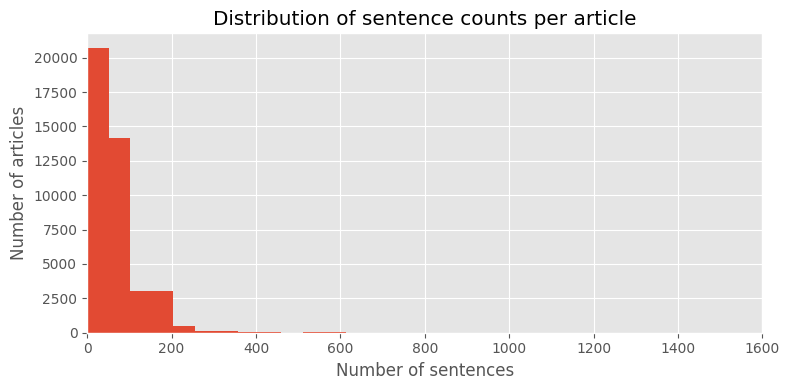

In [13]:
import re

def count_sentences(text: str) -> int:
    """The number of sentences in a raw article text is returned."""
    if not isinstance(text, str):
        return 0
    parts = re.split(r"(?<=[.!?])\s+", text)
    return sum(1 for p in parts if p.strip())

# Sentence counts per article are computed.
articles_with_text["n_sentences"] = articles_with_text["text"].apply(count_sentences)

# The distribution of sentence counts is plotted.
plt.figure(figsize=(8, 4))
articles_with_text["n_sentences"].plot(kind="hist", bins=30)
plt.title("Distribution of sentence counts per article")
plt.xlabel("Number of sentences")
plt.ylabel("Number of articles")
plt.xlim(0, 1600)
plt.tight_layout()
plt.show()


In [14]:
max_sentences = articles_with_text["n_sentences"].max()
print(max_sentences)

1534


In [15]:
articles_with_text.columns

Index(['SOURCEURL', 'SQLDATE', 'domain', 'title', 'entity', 'label', 'count',
       'entity_original', 'TEXT_FILE', 'text', 'n_sentences'],
      dtype='object')

## 7. Article Date Validation

To align the news data with stock-market information and daily sentiment time series, the `SQLDATE` field must be converted from GDELT’s numeric format (`YYYYMMDD`, often stored as a float) into a valid calendar date.

### Method

- `SQLDATE` is cast to a nullable integer (`Int64`) and then to string.  
- The strings are parsed with `pd.to_datetime` using the explicit format `'%Y%m%d'`.  
- The minimum and maximum publication dates are then computed.

In symbolic form, the transformation is:

$$
\text{SQLDATE}_{\text{numeric}}
\;\rightarrow\;
\text{Int64}
\;\rightarrow\;
\text{string}
\;\rightarrow\;
\text{datetime}(\%Y\%m\%d).
$$

### Results

- Earliest article date: **2025-01-01**  
- Latest article date: **2025-10-08**

All retained articles therefore contain valid chronological timestamps, and the dataset is well-structured for time-series analyses of news volume, sentiment dynamics, and their correspondence with Tesla stock movements.

The SQLDATE field from the GDELT mapping file is stored as a numeric YYYYMMDD value (e.g., 20250101). To avoid misinterpretation as a UNIX timestamp, the values were first cast to strings and then parsed explicitly using the format '%Y%m%d'. This yields correct calendar dates for all articles, which are later used to align news coverage with stock price data

In [16]:
## 7. Checking the Range of Article Dates

# SQLDATE is converted from a numeric YYYYMMDD code to a proper datetime.
articles_df["SQLDATE"] = pd.to_datetime(
    articles_df["SQLDATE"].astype("Int64").astype(str),
    format="%Y%m%d",
    errors="coerce"
)

# The minimum and maximum publication dates are obtained.
min_date = articles_df["SQLDATE"].min()
max_date = articles_df["SQLDATE"].max()

print("Articles date range:", min_date, "to", max_date)


Articles date range: 2025-01-01 00:00:00 to 2025-10-08 00:00:00


##Pre-processing and de-duplicating entities

In [17]:
# 7. Entity preprocessing and removal of duplicate entries

# Simple normalisation of selected entities is carried out so that duplicates are reduced.
canonical_map = {
    "tesla": "Tesla",
    "tesla, inc.": "Tesla",
    "elon": "Elon Musk",
    "musk": "Elon Musk",
    "elon musk": "Elon Musk",
    "u.s.": "the US",
    "us": "the US",
    "usa": "the US",
    "united states": "the US",
    # This dictionary can be extended with other variants when needed.
}

def normalise_entity(e: str) -> str:
    """Surface forms are mapped to canonical entities and values that are not strings are left unchanged."""
    if not isinstance(e, str):
        return e
    key = e.strip().lower()
    return canonical_map.get(key, e.strip())

# The filtered entity mentions with dates and text file names are loaded.
file_name = "df_ungrouped_with_sqldate_clean_2025-11-12_1546.csv"
df_mentions = pd.read_csv(BASE_DIR / file_name)

# Entity normalisation is applied.
df_mentions["entity"]         = df_mentions["entity"].apply(normalise_entity)
df_mentions["entity_original"] = df_mentions["entity_original"].apply(normalise_entity)

# SQLDATE is converted correctly from numeric YYYYMMDD values to datetime values.
df_mentions["SQLDATE"] = pd.to_datetime(
    df_mentions["SQLDATE"].astype("Int64").astype(str),
    format="%Y%m%d",
    errors="coerce"
)

print("Mentions date range:",
      df_mentions["SQLDATE"].min(),
      "to",
      df_mentions["SQLDATE"].max())
print("Rows in df_mentions:", df_mentions.shape)


Mentions date range: 2025-01-01 00:00:00 to 2025-10-08 00:00:00
Rows in df_mentions: (42908, 9)


## 7a. Entity Category Share

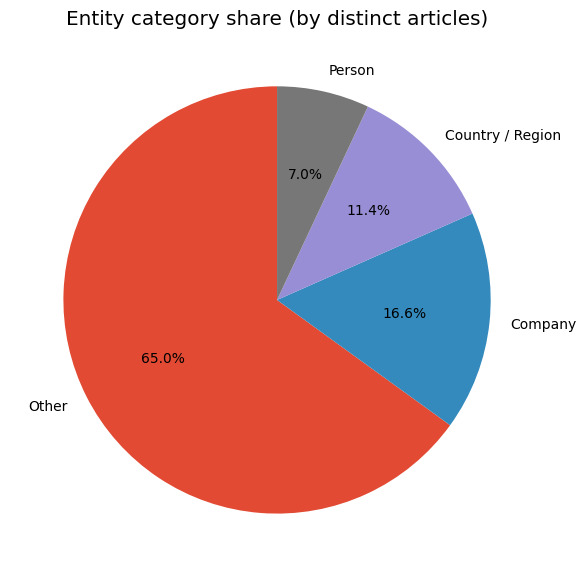

In [18]:
# 7a. Entity Category Share

# A simple entity category is inferred from the original entity string.
def infer_entity_category(name: str) -> str:
    """A coarse category label is returned for an entity name."""
    if not isinstance(name, str):
        return "Other"

    n = name.strip().lower()

    # Entities that refer to persons are detected.
    if any(x in n for x in ["elon musk", "musk", "elon"]):
        return "Person"

    # Entities that refer to companies are detected.
    if "tesla" in n or any(x in n for x in ["inc", "corp", "ltd", "co."]):
        return "Company"

    # Entities that refer to countries or regions are detected.
    country_like = {
        "the us", "united states", "u.s.", "usa",
        "china", "germany", "france", "uk", "britain",
        "europe", "european union", "eu"
    }
    if n in country_like:
        return "Country / Region"

    # Remaining entities are placed into a residual category.
    return "Other"


# The category column is created once so that repeated computation is avoided.
if "entity_category" not in df_mentions.columns:
    df_mentions["entity_category"] = df_mentions["entity_original"].apply(
        infer_entity_category
    )

# Counts of distinct articles per entity category are computed.
cat_counts = (
    df_mentions
    .groupby("entity_category")["TEXT_FILE"]
    .nunique()
    .sort_values(ascending=False)
)

# The share of each entity category is plotted as a pie chart.
plt.figure(figsize=(6, 6))
plt.pie(cat_counts, labels=cat_counts.index, autopct="%1.1f%%", startangle=90)
plt.title("Entity category share (by distinct articles)")
plt.tight_layout()
plt.show()


8. Generating a Per Sentence or Article Pair Dataset with Dates

In this section the entity co occurrence statistics are recomputed by use of the filtered list of entities and the VADER sentiment analyser. For each article the text is divided into sentences, the entities are obtained from the pre processed metadata, and all unique pairs of entities are evaluated. The SQLDATE value of each article is recorded for every pair occurrence so that daily aggregates can be produced later. This step is computationally expensive and should be run only when the files pair_stats_per_article_with_date.csv and pair_stats_daily.csv are not already available.

In [ ]:
## 8. Generating a Per-Sentence or Article Pair Dataset with Dates (optimised)

import itertools
import re
import time
from nltk.sentiment.vader import SentimentIntensityAnalyzer

# The VADER lexicon is ensured to be available.
import nltk
nltk.download("vader_lexicon", quiet=True)
sia = SentimentIntensityAnalyzer()

# df_mentions has already been loaded and normalised in the previous cell
#   columns include SQLDATE, TEXT_FILE, entity, entity_original and count
# The data are grouped by TEXT_FILE so that each article is processed once.
groups = df_mentions.groupby("TEXT_FILE")
print("Number of articles to process:", len(groups))

# ------------------------------------------------------------------
# Texts that are already in memory are used instead of repeatedly reading files from disk
# ------------------------------------------------------------------
# articles_with_text was loaded from Parquet in Section 6
#   columns include TEXT_FILE and text
text_map = dict(
    zip(articles_with_text["TEXT_FILE"], articles_with_text["text"])
)

missing_texts = set()
MAX_ENTITIES_PER_FILE = 40  # this limit is applied so that very large combinations are avoided


def fast_sentence_split(text: str):
    """A simple sentence splitter based on a regular expression is used."""
    sentences = re.split(r"(?<=[.!?])\s+", text)
    return [s.strip() for s in sentences if s.strip()]


pair_records = []
start_time = time.time()

for idx, (text_file, rows) in enumerate(groups, start=1):

    text = text_map.get(text_file)
    if not isinstance(text, str) or not text.strip():
        missing_texts.add(text_file)
        continue  # no text is available for this article

    # 1) Sentences are extracted and sentiment is computed for each sentence.
    sentences = fast_sentence_split(text)
    sentence_sentiment = [sia.polarity_scores(s)["compound"] for s in sentences]

    # 2) Normalised entities and original mentions are collected for this article.
    entities = list(rows["entity"].values)
    mentions = list(rows["entity_original"].values)
    article_entities = [
        {"entity": e, "mention": m} for e, m in zip(entities, mentions)
    ]

    # Extremely long entity lists are shortened so that runtime remains manageable.
    if len(article_entities) > MAX_ENTITIES_PER_FILE:
        article_entities = article_entities[:MAX_ENTITIES_PER_FILE]

    # 3) Each entity is mapped to the set of sentence indices in which it appears.
    entity_to_sent_idxs = {e["entity"]: set() for e in article_entities}
    for i, s in enumerate(sentences):
        for ent in article_entities:
            if ent["mention"] in s:
                entity_to_sent_idxs[ent["entity"]].add(i)

    # 4) Per entity counts are precomputed so that co occurrence weighting can be applied.
    counts_per_entity = rows.set_index("entity")["count"].to_dict()

    # 5) The SQLDATE for this article is obtained (this field was normalised earlier).
    date = rows["SQLDATE"].iloc[0]

    # 6) Records for each entity pair are constructed.
    for e1, e2 in itertools.combinations(article_entities, 2):
        ent1, ent2 = e1["entity"], e2["entity"]
        common_idxs = (
            entity_to_sent_idxs.get(ent1, set())
            & entity_to_sent_idxs.get(ent2, set())
        )
        if not common_idxs:
            continue

        co_occurrence = min(
            counts_per_entity.get(ent1, 0),
            counts_per_entity.get(ent2, 0),
        )
        sentiments = [sentence_sentiment[i] for i in common_idxs]

        pair_records.append(
            {
                "SQLDATE": date,
                "TEXT_FILE": text_file,          # the article identifier is retained
                "entity_1": ent1,
                "entity_2": ent2,
                "co_occurrence": co_occurrence,
                "sentiments": sentiments,
            }
        )

elapsed = time.time() - start_time
print(f"Processed {len(groups)} articles in {elapsed/60:.1f} minutes.")
print(f"Articles with missing text: {len(missing_texts)}")

# ------------------------------------------------------------------
# A per article pair dataframe and the daily aggregates are constructed
# ------------------------------------------------------------------
if pair_records:
    pair_df = pd.DataFrame(pair_records)

    # Sentiment statistics at the article level are computed.
    pair_df["avg_sentiment_article"] = pair_df["sentiments"].apply(
        lambda s: float(np.mean(s)) if s else 0.0
    )
    pair_df["std_sentiment_article"] = pair_df["sentiments"].apply(
        lambda s: float(np.std(s)) if len(s) > 1 else 0.0
    )

    print("Pair-level DataFrame shape:", pair_df.shape)
    display(pair_df.head())

    # Daily values are aggregated by date and pair. The TEXT_FILE column is not used here.
    daily_pair_stats = (
        pair_df
        .groupby(["SQLDATE", "entity_1", "entity_2"])
        .agg(
            co_occurrence=("co_occurrence", "sum"),
            avg_sentiment=("avg_sentiment_article", "mean"),
            std_sentiment=("std_sentiment_article", "mean"),
            n_sentences=("sentiments", lambda lsts: sum(len(l) for l in lsts)),
        )
        .reset_index()
    )

    print("Daily pair stats shape:", daily_pair_stats.shape)
    display(daily_pair_stats.head())

    # Outputs are saved for later use in daily graphs and Tesla specific features.
    per_article_output = BASE_DIR / "pair_stats_per_article_with_date.csv"
    daily_output = BASE_DIR / "pair_stats_daily.csv"
    pair_df.to_csv(per_article_output, index=False)
    daily_pair_stats.to_csv(daily_output, index=False)
    print("Saved per-article pair stats to:", per_article_output)
    print("Saved daily pair stats to:", daily_output)
else:
    print("No pair records were generated. Check that df_mentions and articles_with_text align.")


In [19]:
pair_df=pd.read_csv(BASE_DIR /"pair_stats_per_article_with_date.csv")
daily_pair_stats = pd.read_csv(BASE_DIR / "pair_stats_daily.csv")

import ast

# The SQLDATE column is converted into datetime values.
pair_df["SQLDATE"] = pd.to_datetime(pair_df["SQLDATE"], errors="coerce")

# String representations of lists are converted back into Python list objects.
pair_df["sentiments"] = pair_df["sentiments"].apply(
    lambda v: ast.literal_eval(v) if isinstance(v, str) else v
)


In [20]:
display( daily_pair_stats.head())
display(pair_df.sort_values(by=["SQLDATE","entity_1"]).head())

,SQLDATE,entity_1,entity_2,co_occurrence,avg_sentiment,std_sentiment,n_sentences
0,2025-01-01,Abou Zahab,HPE,9,0.49472,0.412213,5
1,2025-01-01,Amazonas,Dara Khosrowshahi,8,0.57915,0.274828,4
2,2025-01-01,Amazonas,Uber,8,0.78760,0.000000,1
3,2025-01-01,Bloomberg,SPACEX,7,0.00000,0.000000,1
4,2025-01-01,CDP,Suncor,8,-0.52985,0.027550,2


,SQLDATE,TEXT_FILE,entity_1,entity_2,co_occurrence,sentiments,avg_sentiment_article,std_sentiment_article
4429,2025-01-01,004097_itwire_com_ict-energy-and-sustainabilit...,Abou Zahab,HPE,9,"[0.6808, 0.8591, 0.9337, 0.0, 0.0]",0.49472,0.412213
45321,2025-01-01,015870_www_ibtimes_co_uk_uber-ceo-open-tesla-c...,Amazonas,Dara Khosrowshahi,8,"[0.8744, 0.1779, 0.4767, 0.7876]",0.57915,0.274828
45322,2025-01-01,015870_www_ibtimes_co_uk_uber-ceo-open-tesla-c...,Amazonas,Uber,8,[0.7876],0.78760,0.000000
6464,2025-01-01,006925_techcrunch_com_2025_01_01_internal-spac...,Bloomberg,SPACEX,7,[0.0],0.00000,0.000000
42128,2025-01-01,011887_www_denverpost_com_2024_12_31_suncor-en...,CDP,Suncor,8,"[-0.5574, -0.5023]",-0.52985,0.027550


##Small sanity-check

In [21]:
import re

# The same quick sentence splitter that was used in Section 8 is defined again.
def fast_sentence_split(text: str):
    """Text is split into sentences by the use of simple punctuation rules."""
    if not isinstance(text, str):
        return []
    sentences = re.split(r'(?<=[.!?])\s+', text)
    return [s.strip() for s in sentences if s.strip()]


In [22]:

# A simple consistency check is carried out by comparing co_occurrence with the number of sentiment scores.
pair_df['n_sentences_calc'] = pair_df['sentiments'].apply(len)

print("Sample rows where co_occurrence and n_sentences differ:")
display(
    pair_df.loc[pair_df['co_occurrence'] != pair_df['n_sentences_calc']]
           .head(5)
          [['SQLDATE', 'TEXT_FILE', 'entity_1', 'entity_2',
            'co_occurrence', 'n_sentences_calc', 'avg_sentiment_article']]
)

# An example row is selected for inspection.
example = pair_df.iloc[0]  # or a row from the displayed sample can be chosen
print("\nExample pair:")
print(example[['SQLDATE', 'TEXT_FILE', 'entity_1', 'entity_2',
               'co_occurrence', 'n_sentences_calc']])

# An example pair with the largest value of co_occurrence is selected for further inspection.
example = pair_df.sort_values("co_occurrence", ascending=False).iloc[0]

print("Example pair:")
display(example[["SQLDATE", "TEXT_FILE", "entity_1", "entity_2", "co_occurrence"]])

e1 = example["entity_1"]
e2 = example["entity_2"]
text_file_id = example["TEXT_FILE"]

# The article text is retrieved from the dataframe that is held in memory.
article_text = (
    articles_with_text
    .loc[articles_with_text["TEXT_FILE"] == text_file_id, "text"]
    .iloc[0]
)

# The same sentence splitter that was used in Section 8 is applied.
sentences = fast_sentence_split(article_text)

# Sentences in which both entities appear are collected.
sentences_with_both = [
    s for s in sentences
    if e1 in s and e2 in s
]

print(f"\nStored co_occurrence: {example['co_occurrence']}")
print(f"Sentences where both appear (len): {len(sentences_with_both)}\n")

for i, s in enumerate(sentences_with_both, start=1):
    print(f"[{i}] {s}\n")


Sample rows where co_occurrence and n_sentences differ:


,SQLDATE,TEXT_FILE,entity_1,entity_2,co_occurrence,n_sentences_calc,avg_sentiment_article
0,2025-07-17,000001_baystreet_ca_articles_commodities_11304...,Puerto Rico’s,New Fortress Energy Inc.'s,7,5,0.190520
1,2025-07-25,000003_baystreet_ca_articles_commodities_11320...,European Union’s,slovakia,8,7,0.036143
2,2025-07-14,000011_baystreet_ca_commodities_8075_Puerto-Ri...,New Fortress Energy Inc.'s,Puerto Rico’s,7,5,0.190520
4,2025-09-29,000021_colombogazette_com_2025_09_29_sri-lanka...,IAA,the Government of Sri Lanka,8,4,0.823275
6,2025-02-20,000030_indiablooms_com_world_very-unfair-donal...,India,Tesla,7,8,-0.035075



Example pair:
SQLDATE                                           2025-07-17 00:00:00
TEXT_FILE           000001_baystreet_ca_articles_commodities_11304...
entity_1                                                Puerto Rico’s
entity_2                                   New Fortress Energy Inc.'s
co_occurrence                                                       7
n_sentences_calc                                                    5
Name: 0, dtype: object
Example pair:


,7241
SQLDATE,2025-03-18 00:00:00
TEXT_FILE,007591_timesofindia_indiatimes_com_science_sun...
entity_1,Sunita Williams'
entity_2,Sunita Williams'
co_occurrence,93



Stored co_occurrence: 93
Sentences where both appear (len): 14

[1] Students gathered to celebrate the occasion by performing garba and took out a procession with Sunita Williams' photo to the nearby temple of goddess Dola Mata.

[2] "At 9am, 450 students, teachers, and villagers gathered, carrying the ‘Akhand Jyot' (eternal flame), they had kept alive for Sunita Williams' safe return, through the streets.

[3] 03:56 (IST) Mar 20
'It's great news': Sara Sabry welcomes Sunita Williams' return to Earth after nine months
Egyptian Astronaut Sara Sabry, Founder and CEO of Deep Space Initiative, has expressed her excitement and joy over NASA Astronaut Sunita Williams's return to Earth after a nine-month stint in space.

[4] 03:14 (IST) Mar 20
Anupam Kher, Shilpa Shetty react on Sunita Williams' safe return to Earth after historic space mission
The film fraternity is celebrating astronaut Sunita Williams's safe return to Earth after an intense space mission.

[5] 01:20 (IST) Mar 20
No limits

Entity Pair Construction and Sentence Level Sentiment Extraction

This section describes how the dataset of entity co occurrences and sentence level sentiment was produced. The aim of this procedure is to identify sentences in which two entities appear together and to assign a sentiment value to their shared context. The resulting features are used in later sections for daily trend analysis and network based modelling.

Method

1. Article grouping
The metadata containing entity mentions was grouped by TEXT_FILE so that each article was handled once.

2. Text loading and sentence segmentation
The text corresponding to each article was retrieved from the in memory dataset.
The text was divided into sentences by means of a regular expression rule.
A VADER compound sentiment score was computed for every sentence.

3. Entity extraction and pruning
The entities listed in the metadata were associated with the article.
To limit computational cost, at most forty entities were kept per article.

4. Locating entity mentions in sentences
For each entity, the set of sentence indices in which its surface form appeared was determined.
This mapping allowed the identification of sentences in which two entities occurred together.

5. Entity pair construction
A pair was retained only when both entities appeared in at least one common sentence.
For every such pair the following information was stored:

the publication date SQLDATE

the two entities

a co occurrence weight given by the minimum of their mention counts

the list of sentiment scores from the sentences in which both entities appeared

6. Article level sentiment statistics
For each pair the mean and standard deviation of its sentence level sentiment values were computed.

7. Daily aggregation
The entity pairs were aggregated by date to obtain daily totals of co occurrence, the daily mean sentiment, the daily variation in sentiment, and the number of shared sentences.

8. Saving outputs
Two datasets were written to storage:

pair_stats_per_article_with_date.csv, which contains article level records

pair_stats_daily.csv, which contains daily aggregated values

Results

A total of 23,635 articles with valid text were processed.
The extraction procedure produced 55,583 valid sentence level co occurrence records, corresponding to an average of approximately 2.3 entity pairs per article, which is expected because only pairs that share at least one sentence are retained.
After aggregation by day, 47,696 unique entity pair and date combinations were obtained.
These values are consistent with the typical sparsity of co occurrence patterns observed in large news corpora.


## 9.a) Constructing Daily and Cumulative Pair Metrics

In this section the daily and cumulative statistics for the subset of entity pairs connected to the Tesla ego neighborhood are produced. Only the rows in which at least one of the two entities belongs to a predefined Tesla related list are retained. The file pair_stats_daily.csv is used as the input, and it contains one row for each entity pair on each date with variables such as co occurrence count, daily mean sentiment and daily sentiment variability.

After the Tesla related rows are selected, the values are summarised across all relevant pairs for each date. The total co occurrence, the mean of the average sentiment and the mean of the sentiment standard deviation are then plotted as time series. A cumulative co occurrence curve is also created by applying a running sum to the daily co occurrence counts.


Rows in daily_pair_stats: 45901
Rows involving a Tesla-related entity: 9085


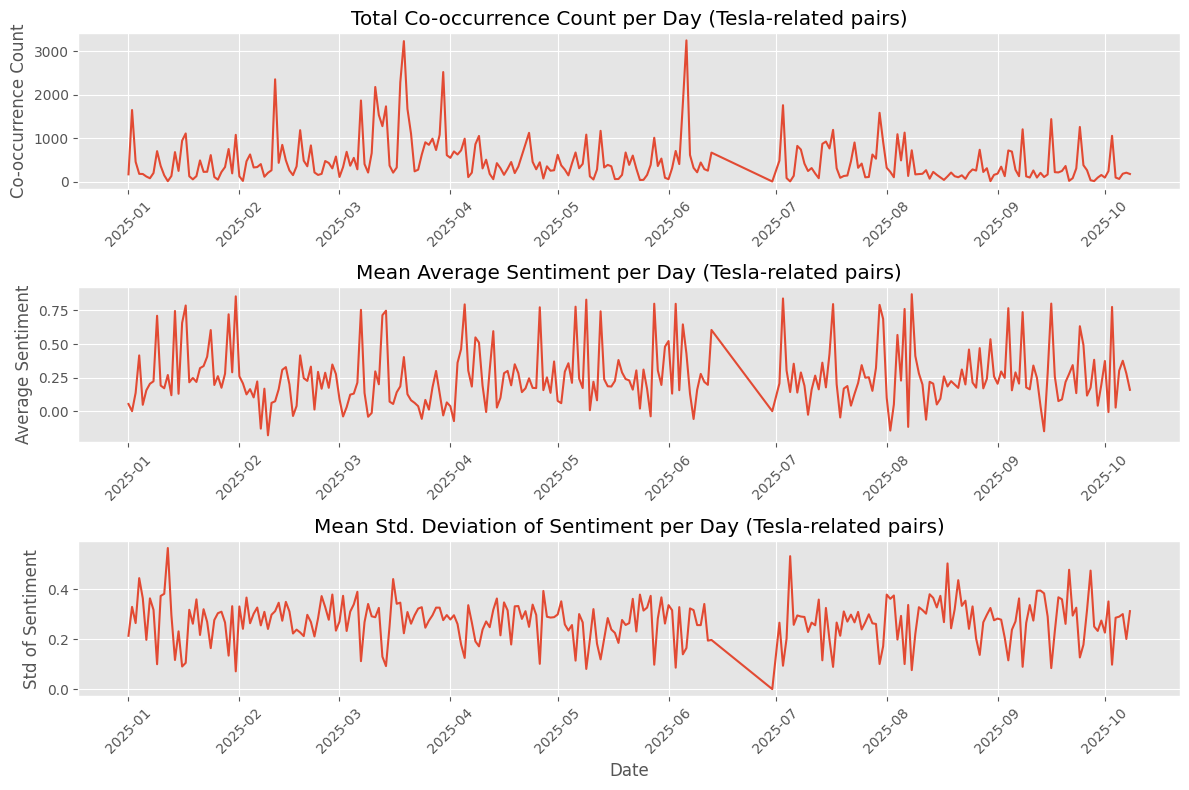

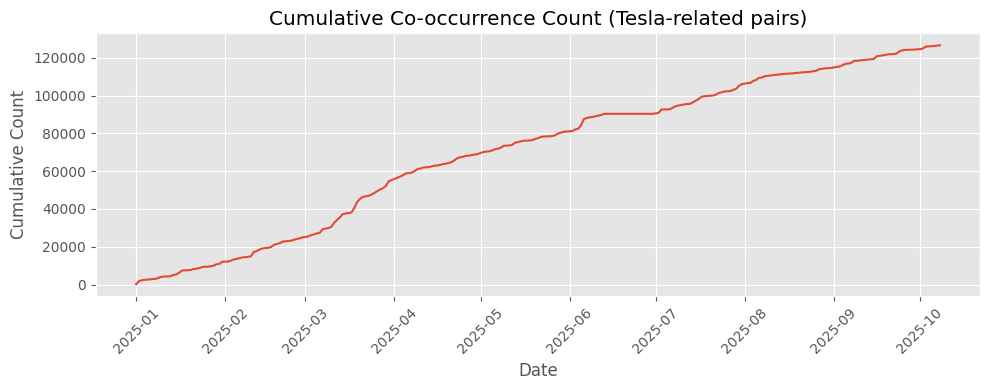

In [23]:
# 9. Daily and cumulative metrics for Tesla-related entity pairs only

daily_file = BASE_DIR / 'pair_stats_daily.csv'

try:
    # The daily pair statistics file is loaded and its SQLDATE column is parsed as datetime.
    daily_pair_stats = pd.read_csv(daily_file, parse_dates=['SQLDATE'])
except FileNotFoundError:
    print("Daily pair statistics file not found; please run Section 8 first.")
    daily_pair_stats = None

if daily_pair_stats is not None:
    # The entities of interest are converted to lower case so that matching can be carried out.
    tesla_nodes = [
        "tesla", "elon musk", "musk", "the us", "the cybertruck owners club",
        "model", "china", "trump", "eastern and southern europe", "canada",
        "autopilot", "waymo", "nhtsa", "optimus", "austin", "samsung",
        "india", "byd", "fbi"
    ]

    # A mask is created so that only pairs in which at least one entity belongs
    # to the Tesla related list are retained.
    mask_tesla = (
        daily_pair_stats['entity_1'].str.lower().isin(tesla_nodes) |
        daily_pair_stats['entity_2'].str.lower().isin(tesla_nodes)
    )

    # The Tesla related subset is extracted.
    tesla_daily = daily_pair_stats.loc[mask_tesla].copy()

    print("Rows in daily_pair_stats:", len(daily_pair_stats))
    print("Rows involving a Tesla-related entity:", len(tesla_daily))

    # A daily summary is produced across all Tesla related pairs.
    daily_summary = tesla_daily.groupby('SQLDATE').agg(
        total_co_occurrence=('co_occurrence', 'sum'),
        mean_avg_sentiment=('avg_sentiment', 'mean'),
        mean_std_sentiment=('std_sentiment', 'mean')
    ).reset_index()

    # Time series plots are generated.
    plt.figure(figsize=(12, 8))

    plt.subplot(3, 1, 1)
    plt.plot(daily_summary['SQLDATE'], daily_summary['total_co_occurrence'])
    plt.title('Total Co-occurrence Count per Day (Tesla-related pairs)')
    plt.ylabel('Co-occurrence Count')
    plt.xticks(rotation=45)

    plt.subplot(3, 1, 2)
    plt.plot(daily_summary['SQLDATE'], daily_summary['mean_avg_sentiment'])
    plt.title('Mean Average Sentiment per Day (Tesla-related pairs)')
    plt.ylabel('Average Sentiment')
    plt.xticks(rotation=45)

    plt.subplot(3, 1, 3)
    plt.plot(daily_summary['SQLDATE'], daily_summary['mean_std_sentiment'])
    plt.title('Mean Std. Deviation of Sentiment per Day (Tesla-related pairs)')
    plt.ylabel('Std of Sentiment')
    plt.xlabel('Date')
    plt.xticks(rotation=45)

    plt.tight_layout()
    plt.show()

    # The cumulative co-occurrence count is computed for Tesla related pairs.
    daily_summary['cumulative_co_occurrence'] = daily_summary['total_co_occurrence'].cumsum()

    plt.figure(figsize=(10, 4))
    plt.plot(daily_summary['SQLDATE'], daily_summary['cumulative_co_occurrence'])
    plt.title('Cumulative Co-occurrence Count (Tesla-related pairs)')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


#9b)

##9b-1 – cumulative daily pair dictionaries

In [24]:
## 9b. Building cumulative daily entity pair statistics

# The rows are sorted by date so that accumulation is carried out in chronological order.
pair_df_sorted = pair_df.sort_values(by="SQLDATE")

daily_entity_pair_dict_list = []
daily_dates = []

for day, rows in pair_df.sort_values("SQLDATE").groupby("SQLDATE"):
    entity_pair_dict = {}

    for _, r in rows.iterrows():
        e1, e2 = r["entity_1"], r["entity_2"]

        # A canonical order independent key is used.
        key = tuple(sorted((e1, e2)))

        if key not in entity_pair_dict:
            entity_pair_dict[key] = {
                "co_occurrence": 0,
                "sentiments": []
            }

        # The co occurrence value is increased and sentiment values are extended.
        entity_pair_dict[key]["co_occurrence"] += int(r["co_occurrence"])
        entity_pair_dict[key]["sentiments"].extend(r["sentiments"])

    # The dictionary for the day is appended to the list.
    daily_entity_pair_dict_list.append(entity_pair_dict)
    daily_dates.append(day)

print("Days in daily_entity_pair_dict_list:", len(daily_entity_pair_dict_list))


Days in daily_entity_pair_dict_list: 267


##9b-2 – building daily NetworkX graphs

In [25]:
daily_graphs = []
daily_graph_dates = []

for day, day_pair_dict in zip(daily_dates, daily_entity_pair_dict_list):

    G = nx.Graph()

    co_occurrences = [d["co_occurrence"] for d in day_pair_dict.values()]
    if not co_occurrences:
        daily_graphs.append(G)
        daily_graph_dates.append(day)
        continue

    threshold = max(5, np.percentile(co_occurrences, 95))

    for (e1, e2), stats in day_pair_dict.items():
        if stats["co_occurrence"] <= threshold:
            continue

        sentiments_array = np.array(stats["sentiments"], dtype=float)
        if sentiments_array.size == 0:
            continue

        G.add_edge(
            e1,
            e2,
            co_occurrence=int(stats["co_occurrence"]),
            sentiment_mean=float(np.mean(sentiments_array)),
            sentiment_std=float(np.std(sentiments_array)),
        )

    daily_graphs.append(G)
    daily_graph_dates.append(day)

print(f"Daily graphs created: {len(daily_graphs)}")


Daily graphs created: 267


In [26]:
## 9b.2 Creating daily graphs from cumulative statistics

daily_graphs = []          # A list of NetworkX graphs is stored.
daily_graph_dates = []     # The same dates as daily_dates are stored for convenience.

for day, day_pair_dict in zip(daily_dates, daily_entity_pair_dict_list):

    G = nx.Graph()

    # The distribution of co occurrences is inspected so that strong edges can be selected.
    co_occurrences = [d["co_occurrence"] for d in day_pair_dict.values()]
    if not co_occurrences:   # A safety check is carried out.
        daily_graphs.append(G)
        daily_graph_dates.append(day)
        continue

    # The ninety fifth percentile is used as a threshold, with a minimum value of five.
    threshold = max(5, np.percentile(co_occurrences, 95))

    for (e1, e2), stats in day_pair_dict.items():
        if stats["co_occurrence"] <= threshold:
            continue

        # Only this part is changed and extended.
        sentiments = stats["sentiments"]
        if isinstance(sentiments, str):
            try:
                sentiments = ast.literal_eval(sentiments)
            except (ValueError, SyntaxError):
                # If a malformed value is encountered, the edge is skipped.
                continue

        sentiments_array = np.array(sentiments, dtype=float)
        # This marks the end of the small change.

        if sentiments_array.size == 0:
            continue

        # Edge attributes are used to store co occurrence and sentiment statistics.
        G.add_edge(
            e1,
            e2,
            co_occurrence=int(stats["co_occurrence"]),
            sentiment_mean=float(np.mean(sentiments_array)),
            sentiment_std=float(np.std(sentiments_array)),
        )

    daily_graphs.append(G)
    daily_graph_dates.append(day)

print(f"Daily graphs created: {len(daily_graphs)}")


Daily graphs created: 267


##9b-3 – helper function for Tesla-ego edge sentiments

In [27]:
## 9b.3 Helper to collect edge sentiments around selected nodes

def collect_edge_sentiments(G: nx.Graph, nodes_of_interest: list):
    """
    For a given graph, sentiment statistics of all edges that touch
    the specified nodes are collected.

    Parameters
    ----------
    G : nx.Graph
        A graph is expected that contains edges with the attributes
        named 'sentiment_mean' and 'sentiment_std'.
    nodes_of_interest : list of str
        Node labels are provided whose incident edges are inspected.

    Returns
    -------
    edge_means : list of float
        A list of sentiment_mean values is returned for all relevant edges.
    edge_stds : list of float
        A list of sentiment_std values is returned for all relevant edges.
    """
    edge_means = []
    edge_stds = []

    for node in nodes_of_interest:
        if node in G:
            for _, edge_data in G[node].items():
                if "sentiment_mean" in edge_data:
                    edge_means.append(edge_data["sentiment_mean"])
                if "sentiment_std" in edge_data:
                    edge_stds.append(edge_data["sentiment_std"])

    return edge_means, edge_stds

## 9b-4 – Tesla-ego features per day
This cell builds a tidy dataframe with Tesla-related features that we can later merge with our stock labels.

In [28]:
## 9b.4 Computing Tesla ego network features for each day

# The same Tesla related nodes as in Section 9 are used and these match the canonical
# entity labels that were used when the graphs were built, for example "Tesla" and "Elon Musk".
tesla_nodes = [ "tesla", "elon musk", "musk", "the US", "the Cybertruck Owners Club", "MODEL", "China", "Trump", "Eastern and Southern Europe", "CANADA", "Autopilot", "Waymo", "NHTSA", "Optimus", "Austin", "Samsung", "India", "BYD", "FBI" ]
tesla_daily_features = []

for day, G in zip(daily_graph_dates, daily_graphs):

    # Edge sentiments around Tesla related nodes are collected.
    edge_means, edge_stds = collect_edge_sentiments(G, tesla_nodes)

    if edge_means:
        # Overall sentiment around the Tesla ego network is summarised.
        mean_sent     = float(np.mean(edge_means))
        var_sent      = float(np.std(edge_means))          # variability of edge means is measured.
        mean_edge_std = float(np.mean(edge_stds)) if edge_stds else np.nan
    else:
        mean_sent     = np.nan
        var_sent      = np.nan
        mean_edge_std = np.nan

    # Degree based measures for Tesla related nodes are computed.
    # G.degree(n) returns a single integer degree value for node n.
    total_degree = sum(G.degree(n) for n in tesla_nodes if n in G)

    # For weighted degree, the co_occurrence edge attribute is used as the weight.
    total_weighted_degree = sum(
        G.degree(n, weight="co_occurrence") for n in tesla_nodes if n in G
    )

    tesla_daily_features.append({
        "SQLDATE": day,
        "tesla_edge_mean_sentiment": mean_sent,
        "tesla_edge_sentiment_variability": var_sent,
        "tesla_edge_std_mean": mean_edge_std,
        "tesla_total_degree": total_degree,
        "tesla_total_weighted_degree": total_weighted_degree,
    })

tesla_features_df = (
    pd.DataFrame(tesla_daily_features)
      .sort_values("SQLDATE")
      .reset_index(drop=True)
)

print("Tesla-ego feature dataframe shape:", tesla_features_df.shape)
display(tesla_features_df.head())


Tesla-ego feature dataframe shape: (267, 6)


,SQLDATE,tesla_edge_mean_sentiment,tesla_edge_sentiment_variability,tesla_edge_std_mean,tesla_total_degree,tesla_total_weighted_degree
0,2025-01-01,-0.012700,0.000000,0.390272,1,31
1,2025-01-02,-0.232960,0.139678,0.513878,4,561
2,2025-01-03,0.071442,0.046646,0.407926,3,99
3,2025-01-04,NaN,NaN,NaN,0,0
4,2025-01-05,0.661059,0.000000,0.198920,1,24


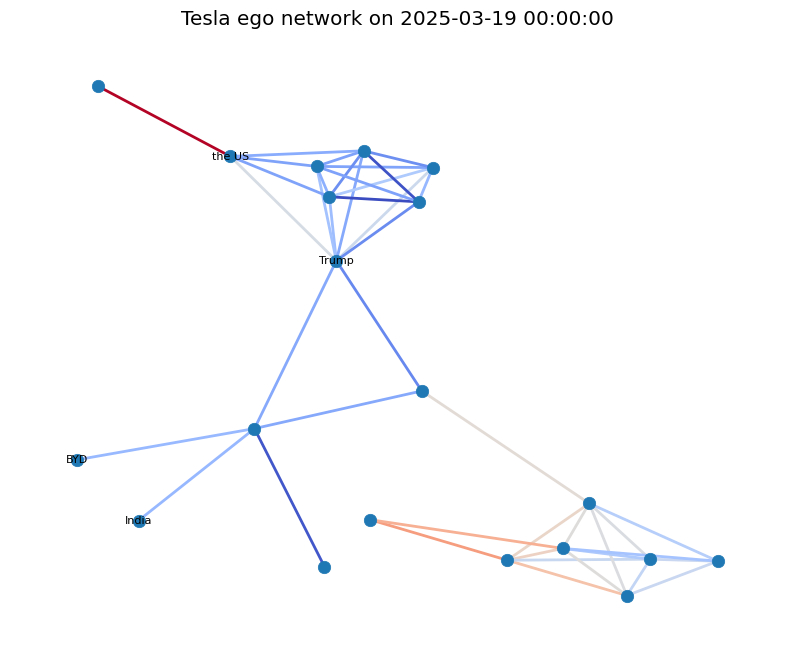

In [29]:
## Optional: a Tesla ego network is visualised for a representative day

# The day with the highest Tesla degree is selected as an example.
idx_max = tesla_features_df["tesla_total_degree"].idxmax()
G_example = daily_graphs[idx_max]
day_example = daily_graph_dates[idx_max]

plt.figure(figsize=(10, 8))
pos = nx.spring_layout(G_example, k=0.4, seed=0)

# Edge colours are set to represent the sentiment_mean attribute.
edge_colors = [
    G_example[u][v]["sentiment_mean"] for u, v in G_example.edges()
]

nx.draw_networkx_nodes(G_example, pos, node_size=80)
nx.draw_networkx_edges(
    G_example, pos,
    edge_color=edge_colors,
    edge_cmap=plt.cm.coolwarm,
    width=2,
)
# Only the Tesla related nodes are labelled so that the figure remains readable.
labels = {n: n for n in G_example.nodes() if n in tesla_nodes}
nx.draw_networkx_labels(G_example, pos, labels, font_size=8)

plt.title(f"Tesla ego network on {day_example}")
plt.axis("off")
plt.show()


##9b-5 – merge Tesla features with stock labels
If our stock_data index is a DatetimeIndex labelled Date, we can align features and labels like this:

In [30]:
## 9b.5 Aligning Tesla ego features with stock labels (optional)

# Columns from yfinance are flattened when a MultiIndex is present.
stock_for_merge = stock_data.copy()
if isinstance(stock_for_merge.columns, pd.MultiIndex):
    # Only the top level is kept, for example Close, pct_change and label.
    stock_for_merge.columns = [c[0] for c in stock_for_merge.columns.values]

# The index is reset so that the original Date index becomes a column.
stock_for_merge = stock_for_merge.reset_index().rename(columns={"Date": "date"})

# The merge key types are made consistent on both sides.
# Normalised datetime values are used in both dataframes.
tesla_features_df["date"] = pd.to_datetime(tesla_features_df["SQLDATE"]).dt.normalize()
stock_for_merge["date"] = pd.to_datetime(stock_for_merge["date"]).dt.normalize()

# An optional check of the date columns can be carried out here.
# print(tesla_features_df[["SQLDATE", "date"]].head())
# print(stock_for_merge[["date"]].head(), stock_for_merge.dtypes)

# The two tables are now safely merged on the date column.
tesla_stock_df = pd.merge(
    tesla_features_df,
    stock_for_merge[["date", "pct_change", "label"]],
    on="date",
    how="inner"
)

print("Merged Tesla features + stock labels shape:", tesla_stock_df.shape)
display(tesla_stock_df.head())

Merged Tesla features + stock labels shape: (183, 9)


,SQLDATE,tesla_edge_mean_sentiment,tesla_edge_sentiment_variability,tesla_edge_std_mean,tesla_total_degree,tesla_total_weighted_degree,date,pct_change,label
0,2025-01-02,-0.232960,0.139678,0.513878,4,561,2025-01-02,-6.081616,Negative
1,2025-01-03,0.071442,0.046646,0.407926,3,99,2025-01-03,8.215567,Positive
2,2025-01-06,NaN,NaN,NaN,0,0,2025-01-06,0.148617,Neutral
3,2025-01-07,NaN,NaN,NaN,0,0,2025-01-07,-4.060334,Negative
4,2025-01-08,0.342119,0.352055,0.382680,3,66,2025-01-08,0.147078,Neutral


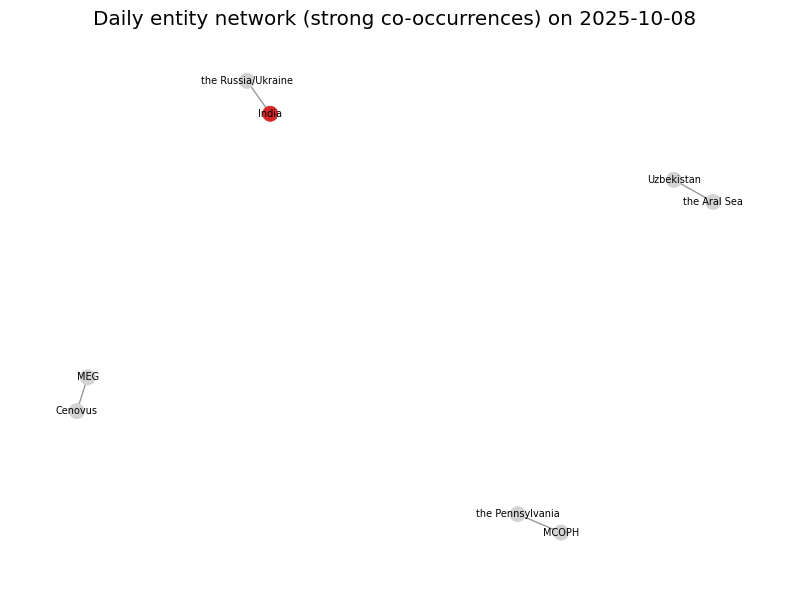

In [31]:
## 9b.6 Example visualisation of a daily Tesla related entity network

# A non empty graph is selected by choosing the last day on which edges are present.
chosen_day = None
chosen_G = None
for day, G in reversed(list(zip(daily_graph_dates, daily_graphs))):
    if G.number_of_edges() > 0:
        chosen_day = day
        chosen_G = G
        break

if chosen_G is None:
    print("No non-empty graphs found to plot.")
else:
    plt.figure(figsize=(8, 6))
    pos = nx.spring_layout(chosen_G, k=0.35, seed=42)

    # Nodes that are incident to Tesla related entities are highlighted.
    tesla_nodes = [ "tesla", "elon musk", "musk", "the US", "the Cybertruck Owners Club", "MODEL", "China", "Trump", "Eastern and Southern Europe", "CANADA", "Autopilot", "Waymo", "NHTSA", "Optimus", "Austin", "Samsung", "India", "BYD", "FBI" ]

    node_colors = [
        "tab:red" if n in tesla_nodes else "lightgrey"
        for n in chosen_G.nodes()
    ]

    nx.draw_networkx_nodes(chosen_G, pos, node_size=120, node_color=node_colors)
    nx.draw_networkx_edges(chosen_G, pos, alpha=0.4)
    nx.draw_networkx_labels(chosen_G, pos, font_size=7)

    plt.title(f"Daily entity network (strong co-occurrences) on {chosen_day.date()}")
    plt.axis("off")
    plt.tight_layout()
    plt.show()

## 10.a) Quick EDA of Tesla-ego features

In [32]:
## 10.a) Tesla ego feature overview

print("tesla_stock_df shape:", tesla_stock_df.shape)
print("\nColumns:", tesla_stock_df.columns.tolist())

# Rows that contain valid graph features and a label are retained.
feat_cols = [
    "tesla_edge_mean_sentiment",
    "tesla_edge_sentiment_variability",
    "tesla_edge_std_mean",
    "tesla_total_degree",
    "tesla_total_weighted_degree",
]
eda_df = tesla_stock_df.dropna(subset=feat_cols + ["label"]).copy()

# The distribution of labels is displayed.
print("\nLabel distribution:")
print(eda_df["label"].value_counts())

# Summary statistics for the Tesla ego features are displayed.
print("\nFeature summary:")
print(eda_df[feat_cols].describe())


tesla_stock_df shape: (183, 9)

Columns: ['SQLDATE', 'tesla_edge_mean_sentiment', 'tesla_edge_sentiment_variability', 'tesla_edge_std_mean', 'tesla_total_degree', 'tesla_total_weighted_degree', 'date', 'pct_change', 'label']

Label distribution:
label
Neutral     63
Positive    47
Negative    40
Name: count, dtype: int64

Feature summary:
       tesla_edge_mean_sentiment  tesla_edge_sentiment_variability  \
count                 150.000000                        150.000000   
mean                    0.265658                          0.099882   
std                     0.294098                          0.138733   
min                    -0.423250                          0.000000   
25%                     0.072054                          0.000000   
50%                     0.223357                          0.027325   
75%                     0.399770                          0.144800   
max                     0.948500                          0.536950   

       tesla_edge_std_mean  

## Sanity check for preprocessing and duplicates

In [33]:
sorted(pair_df["entity_1"].str.lower().unique()[:50])

['aef',
 'africa first',
 'apple',
 'australia',
 'ayuk',
 'chile',
 'china',
 'cips',
 'donald trump',
 'eacop',
 'edison',
 'elon musk',
 'emnett',
 'european union’s',
 'g20',
 'gentari',
 'ghana',
 'hyundai motor’s',
 'iaa',
 'india',
 'innocsr',
 'jac',
 'kingdom of senegal',
 'mprest',
 'namibia',
 "new fortress energy inc.'s",
 'norway',
 'omoda',
 'openai',
 "pacific green's",
 'pakistan',
 'palisades',
 'parkland',
 'pidg',
 'puerto rico’s',
 'qatar',
 'silver lake motors’',
 'south africa',
 'tesla',
 'the mozambique',
 'the republic of tajikistan',
 'the russia/ukraine',
 'the us',
 'the vietnam war',
 'totalénergies',
 'trump',
 'turkmenistan',
 'uae',
 'ukraine',
 'uzbekistan']

## 10.b) Entity Pair Statistics (Using `entity_pairs_results.csv`)

A precomputed file `entity_pairs_results.csv` contains overall statistics for each entity pair, including the average
VADER sentiment, the standard deviation and the co‑occurrence count across all articles.  This section loads that file
and produces bar charts showing the most frequent pairs and the pairs with the most extreme sentiment values.


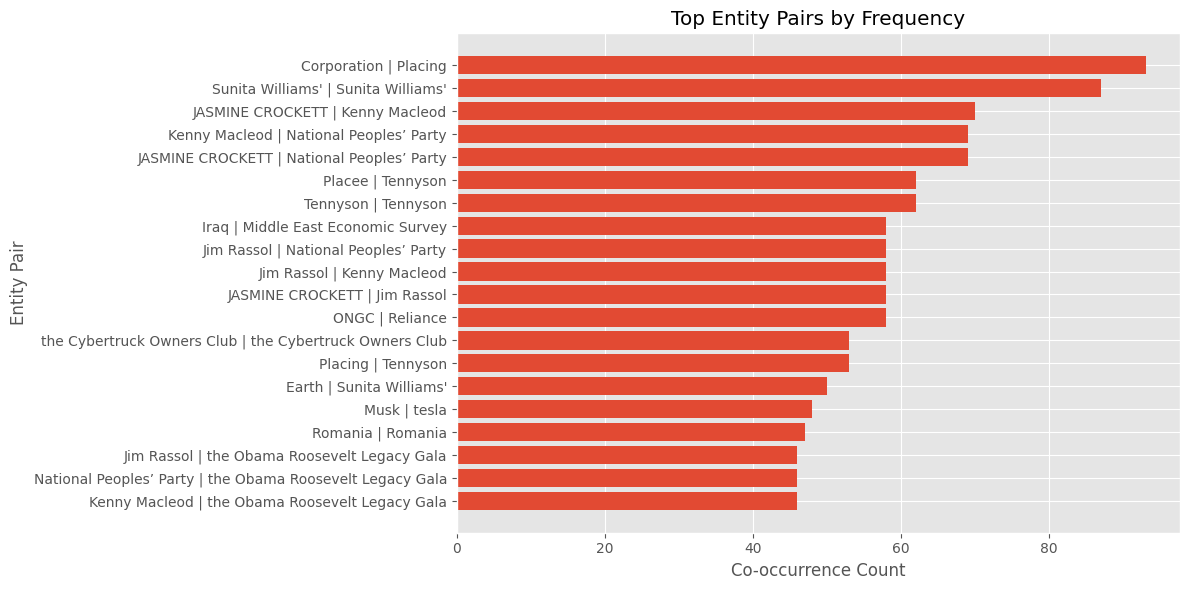

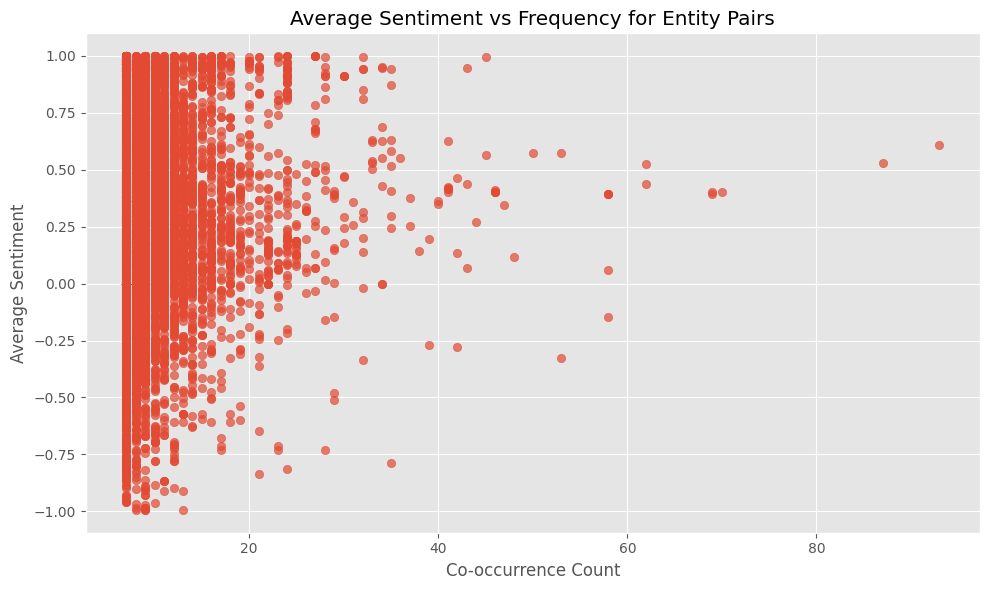

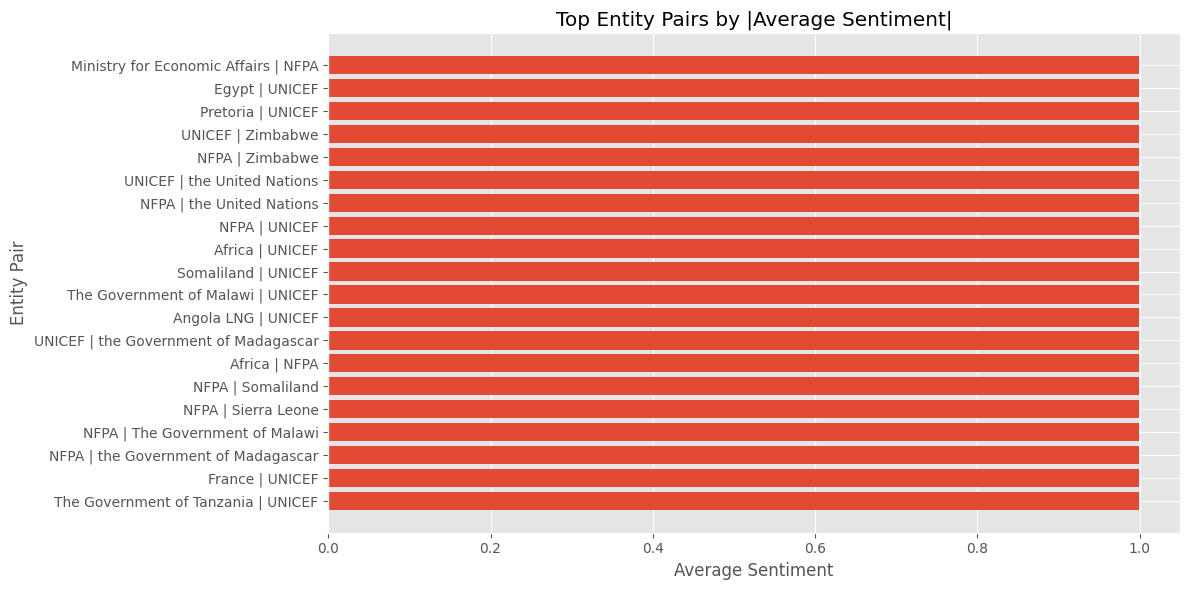

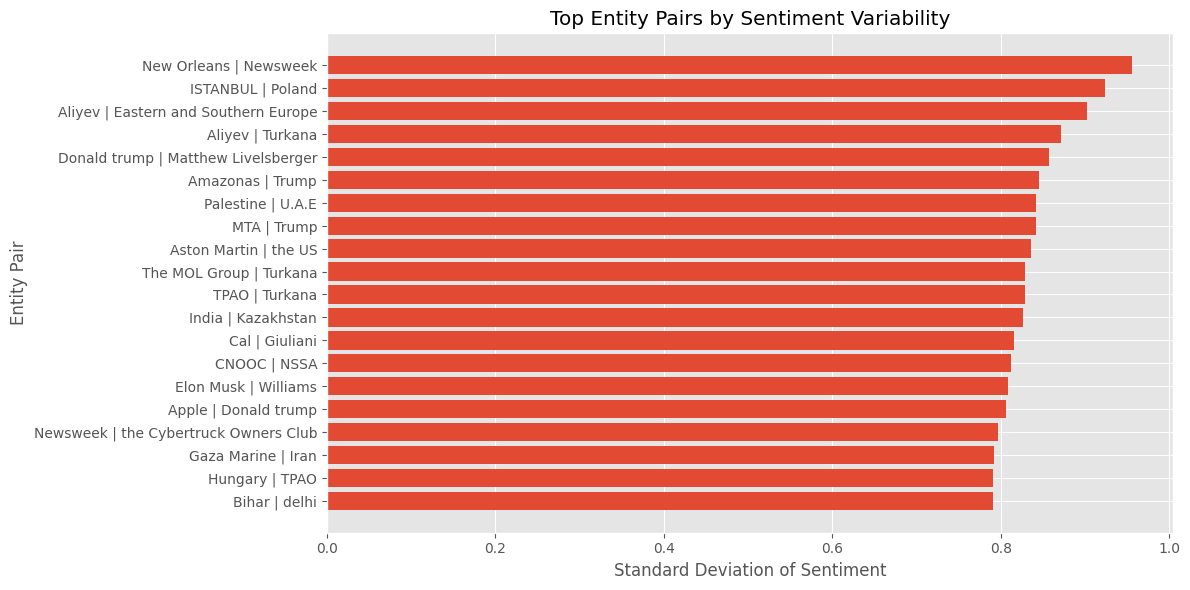

In [34]:
## 10. Entity Pair Statistics (entity_pairs_results.csv is used)
#
# In this section, global statistics for each entity pair are analysed.
# The file `entity_pairs_results.csv` is assumed to contain, for each pair:
#   - entity_1, entity_2
#   - avg_sentiment       (mean VADER compound score)
#   - std_sentiment       (standard deviation of sentiment)
#   - co_occurrence       (overall co occurrence weight across the corpus)
# Optional columns such as n_sentences may also be present.
# The most frequent pairs and those with extreme or highly variable sentiment
# values are visualised.

from pathlib import Path

entity_pairs_path = BASE_DIR / "entity_pairs_results.csv"
df_pairs = pd.read_csv(entity_pairs_path)

# A display label is created for each pair if it does not already exist.
if "pair" not in df_pairs.columns:
    if {"entity_1", "entity_2"}.issubset(df_pairs.columns):
        df_pairs["pair"] = df_pairs["entity_1"] + " | " + df_pairs["entity_2"]
    elif {"entity1", "entity2"}.issubset(df_pairs.columns):
        df_pairs["pair"] = df_pairs["entity1"] + " | " + df_pairs["entity2"]
    else:
        df_pairs["pair"] = df_pairs.index.astype(str)

# A unified count column is ensured for plotting purposes.
if "co_occurrence" in df_pairs.columns:
    df_pairs["count"] = df_pairs["co_occurrence"]
elif "count" not in df_pairs.columns:
    raise ValueError("No 'co_occurrence' or 'count' column found in entity_pairs_results.csv.")

# 10.1 Top 20 pairs by frequency
top_freq = df_pairs.nlargest(20, "count")

plt.figure(figsize=(12, 6))
plt.barh(top_freq["pair"], top_freq["count"])
plt.xlabel("Co-occurrence Count")
plt.ylabel("Entity Pair")
plt.title("Top Entity Pairs by Frequency")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 10.2 Sentiment versus frequency scatter
plt.figure(figsize=(10, 6))
plt.scatter(df_pairs["count"], df_pairs["avg_sentiment"], alpha=0.7)
plt.xlabel("Co-occurrence Count")
plt.ylabel("Average Sentiment")
plt.title("Average Sentiment vs Frequency for Entity Pairs")
plt.tight_layout()
plt.show()

# 10.3 Top 20 pairs by absolute average sentiment
df_pairs["abs_avg_sent"] = df_pairs["avg_sentiment"].abs()
top_abs_sent = df_pairs.nlargest(20, "abs_avg_sent")

plt.figure(figsize=(12, 6))
plt.barh(top_abs_sent["pair"], top_abs_sent["avg_sentiment"])
plt.xlabel("Average Sentiment")
plt.ylabel("Entity Pair")
plt.title("Top Entity Pairs by |Average Sentiment|")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# 10.4 Top 20 pairs by sentiment variability
if "std_sentiment" in df_pairs.columns:
    df_pairs["abs_std_sent"] = df_pairs["std_sentiment"].abs()
    top_std = df_pairs.nlargest(20, "abs_std_sent")

    plt.figure(figsize=(12, 6))
    plt.barh(top_std["pair"], top_std["std_sentiment"])
    plt.xlabel("Standard Deviation of Sentiment")
    plt.ylabel("Entity Pair")
    plt.title("Top Entity Pairs by Sentiment Variability")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()
else:
    print("Column 'std_sentiment' not found; variability plot has been skipped.")


#Part B – Text Analysis

## 11. Extended Text Preprocessing

From this point onwards the focus is shifted from entity level networks to the article text itself. Sections eleven to fifteen make use of the merged `articles_with_text` table and the `advanced_preprocess` function that is defined below.

News articles are cleaned before any analysis at the word level or by means of n grams is carried out. The function below expands contractions, removes addresses and email addresses, strips non alphabetic characters, converts text to lower case, tokenises it, removes stop words and optionally applies stemming or lemmatisation. A short demonstration on a sample sentence is included so that the effect of the transformation can be seen.

In [35]:
## 11. Extended Text Preprocessing (concise version)

import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import SnowballStemmer, WordNetLemmatizer
from nltk.tokenize import word_tokenize

# NLTK resources that are required for tokenisation and lemmatisation are downloaded.
for pkg in ["stopwords", "punkt", "punkt_tab", "wordnet", "omw-1.4"]:
    nltk.download(pkg, quiet=True)

# Components that are reused in the preprocessing function are defined.
url_regex   = re.compile(r"https?://\S+|www\.\S+")
email_regex = re.compile(r"[A-Za-z0-9._%+-]+@[A-Za-z0-9.-]+\.[A-Za-z]{2,}")
stop_words  = set(stopwords.words("english"))
stemmer     = SnowballStemmer("english")
lemmatizer  = WordNetLemmatizer()

def uncontract(text: str) -> str:
    """Basic English contractions are expanded in the text that is provided."""
    patterns = {
        r"can't": "cannot",
        r"n't": " not",
        r"'ll": " will",
        r"'ve": " have",
        r"'d": " would",
        r"'re": " are",
        r"'m": " am",
    }
    for pat, repl in patterns.items():
        text = re.sub(pat, repl, text)
    return text

def advanced_preprocess(text, stem: bool = False, lemmatize: bool = False) -> str:
    """
    News text is normalised in several stages. Contractions are expanded, web addresses
    and email addresses are removed, characters that are not letters are stripped, text
    is converted to lower case and tokenised, stop words are removed and optional
    stemming or lemmatisation is applied.
    """
    if not isinstance(text, str):
        text = ""

    text = uncontract(text)
    text = url_regex.sub(" URL ", text)
    text = email_regex.sub(" EMAIL ", text)
    text = re.sub(r"[^A-Za-z ]+", " ", text).lower()

    tokens = word_tokenize(text)
    cleaned = []
    for tok in tokens:
        if tok not in stop_words and len(tok) > 1:
            if lemmatize:
                tok = lemmatizer.lemmatize(tok)
            elif stem:
                tok = stemmer.stem(tok)
            cleaned.append(tok)

    return " ".join(cleaned)

# A quick demonstration of the preprocessing function is provided.
sample_text = (
    "Email me at example@example.com! Visit https://tesla.com for more info. "
    "I can't believe it's happening!"
)
print("Original:", sample_text)
print("Processed:", advanced_preprocess(sample_text, lemmatize=True))

Original: Email me at example@example.com! Visit https://tesla.com for more info. I can't believe it's happening!
Processed: email email visit url info believe happening


In [36]:
# # Quick test on small subset
# subset = articles_with_text["text"].fillna("").head(200)

# print("Testing preprocessing on 200 articles...")
# tmp_clean = subset.apply(lambda t: advanced_preprocess(t, lemmatize=True))
# tmp_label = subset.apply(label_from_vader)

# print("Example clean text:\n", tmp_clean.iloc[0][:400])
# print("Example label:", tmp_label.iloc[0])


## Defining clean_text, article_sentiment_label & providing sentiment_label

In [ ]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import numpy as np
from pathlib import Path

clean_path = BASE_DIR / "articles_with_text_cleaned.parquet"

# ------------------------------------------------------------------
# If preprocessed texts have already been saved, they are loaded and reused.
# ------------------------------------------------------------------
if clean_path.exists():
    print("Loading preprocessed texts from:", clean_path)
    articles_with_text = pd.read_parquet(clean_path)

else:
    print("No cleaned file found – preprocessing articles now…")

    # 1) A raw text series is prepared.
    text_series = articles_with_text["text"].fillna("")

    # 2) The VADER labeller is defined once.
    nltk.download("vader_lexicon", quiet=True)
    sia = SentimentIntensityAnalyzer()

    def label_from_vader(text: str, pos: float = 0.05, neg: float = -0.05) -> str:
        """Positive, Negative or Neutral is assigned by use of the VADER compound score."""
        if not isinstance(text, str):
            text = ""
        score = sia.polarity_scores(text)["compound"]
        if score > pos:
            return "Positive"
        elif score < neg:
            return "Negative"
        else:
            return "Neutral"

    # 3) The data are processed in chunks so that a single very long apply call is avoided.
    def preprocess_in_chunks(df, chunk_size=3000):
        clean_col = pd.Series(index=df.index, dtype="object")
        label_col = pd.Series(index=df.index, dtype="object")

        n = len(df)
        for start in range(0, n, chunk_size):
            end = min(start + chunk_size, n)
            print(f"  Processing rows {start}–{end-1} / {n}")

            chunk = df["text"].iloc[start:end].fillna("")
            clean_chunk = chunk.apply(lambda t: advanced_preprocess(t, lemmatize=True))
            label_chunk = chunk.apply(label_from_vader)

            clean_col.iloc[start:end] = clean_chunk.values
            label_col.iloc[start:end] = label_chunk.values

        return clean_col, label_col

    clean_text, sentiment_label = preprocess_in_chunks(articles_with_text)

    articles_with_text["clean_text"] = clean_text
    articles_with_text["article_sentiment_label"] = sentiment_label

    # 4) The results are saved so that they can be reused.
    articles_with_text.to_parquet(clean_path, index=False)
    print("Saved cleaned articles to:", clean_path)


In [37]:
clean_path = BASE_DIR / "articles_with_text_cleaned.parquet"
articles_with_text = pd.read_parquet(clean_path)

## 12. Common Words by Sentiment

After cleaning the articles using the `advanced_preprocess` function, the most frequent words can be extracted.
This example computes the top words for sample positive, negative and neutral texts.

In [ ]:
# The sentiment_label column is ensured to be available for later sections.
# This is done after articles_with_text has been loaded from the parquet file.

if "sentiment_label" not in articles_with_text.columns:
    if "article_sentiment_label" in articles_with_text.columns:
        articles_with_text["sentiment_label"] = articles_with_text["article_sentiment_label"]
        print("Created 'sentiment_label' from 'article_sentiment_label'.")
    else:
        raise ValueError(
            "Neither 'sentiment_label' nor 'article_sentiment_label' "
            "found in articles_with_text."
        )

print(articles_with_text[["clean_text", "article_sentiment_label", "sentiment_label"]].head())


Created 'sentiment_label' from 'article_sentiment_label'.
                                          clean_text article_sentiment_label  \
0  url dead tesla cybertruck explodes outside tru...                Negative   
1  url interesting twist regarding tesla cybertru...                Negative   
2  url puerto rico blackout update people remain ...                Positive   
3  url tesla cybertruck explodes outside trump ho...                Negative   
4  url tamil nadu cancel global smart meter tende...                Positive   

  sentiment_label  
0        Negative  
1        Negative  
2        Positive  
3        Negative  
4        Positive  


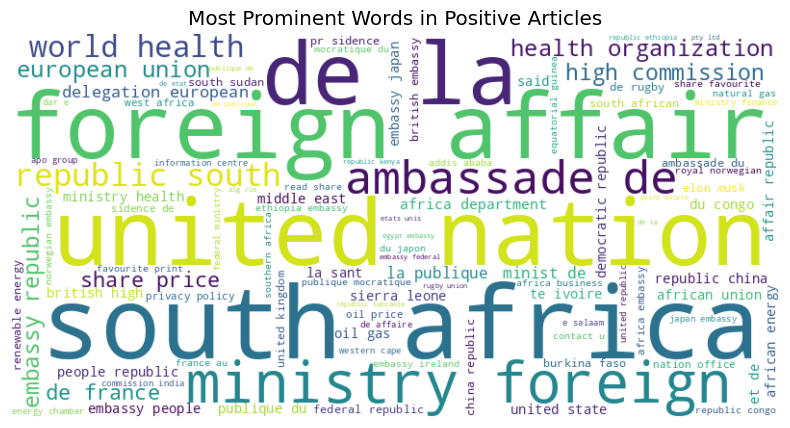

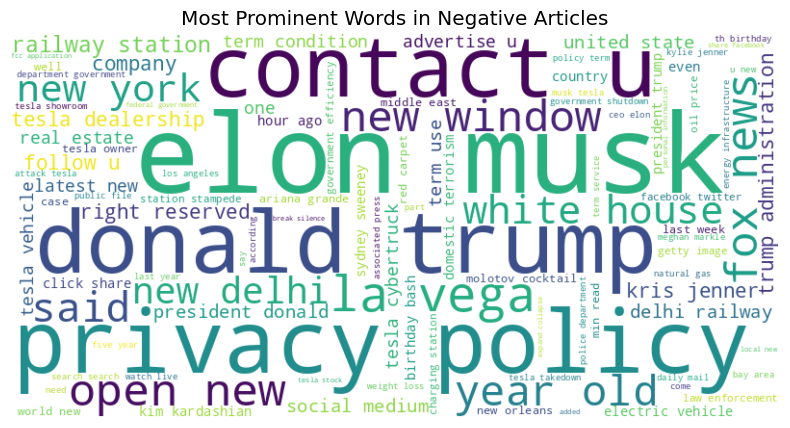

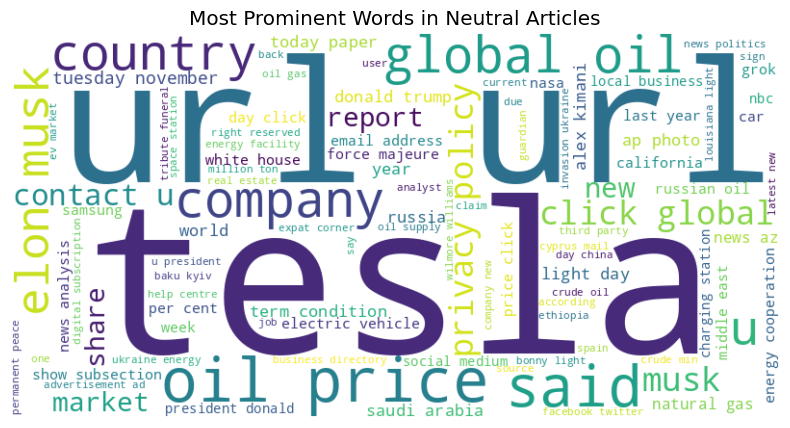

In [ ]:
## 12. Common Words by Sentiment (Word Clouds)

# The wordcloud package is installed once near the beginning of the notebook if it is not already present.
# %pip install -q wordcloud

from wordcloud import WordCloud
import random

def plot_wordcloud_for_label(df, label, max_words=100, sample_n=3000):
    """
    A word cloud is generated for texts with the sentiment label that is provided.
    To keep the computation fast, at most sample_n rows are used.
    """
    # Rows with the required sentiment label are selected.
    subset = df[df["sentiment_label"] == label]

    if subset.empty:
        print(f"No text available for label '{label}'.")
        return

    # A random sample is taken when many rows are available so that computation is sped up.
    if len(subset) > sample_n:
        subset = subset.sample(n=sample_n, random_state=0)

    # Cleaned text values are concatenated into a single string.
    text_blob = " ".join(subset["clean_text"].dropna().astype(str))
    if not text_blob.strip():
        print(f"No text available for label '{label}'.")
        return

    # The word cloud is generated and plotted.
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=max_words
    ).generate(text_blob)

    plt.figure(figsize=(10, 5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Most Prominent Words in {label} Articles")
    plt.show()

# A separate word cloud is generated for each sentiment label.
for lbl in ["Positive", "Negative", "Neutral"]:
    plot_wordcloud_for_label(articles_with_text, lbl)



## 13.Entity Frequency Over Time

To understand which entities dominate the news across time, the filtered entities can be grouped by date and counted.
This example shows how to plot the occurrences of the top entities over time using a mock dataframe.

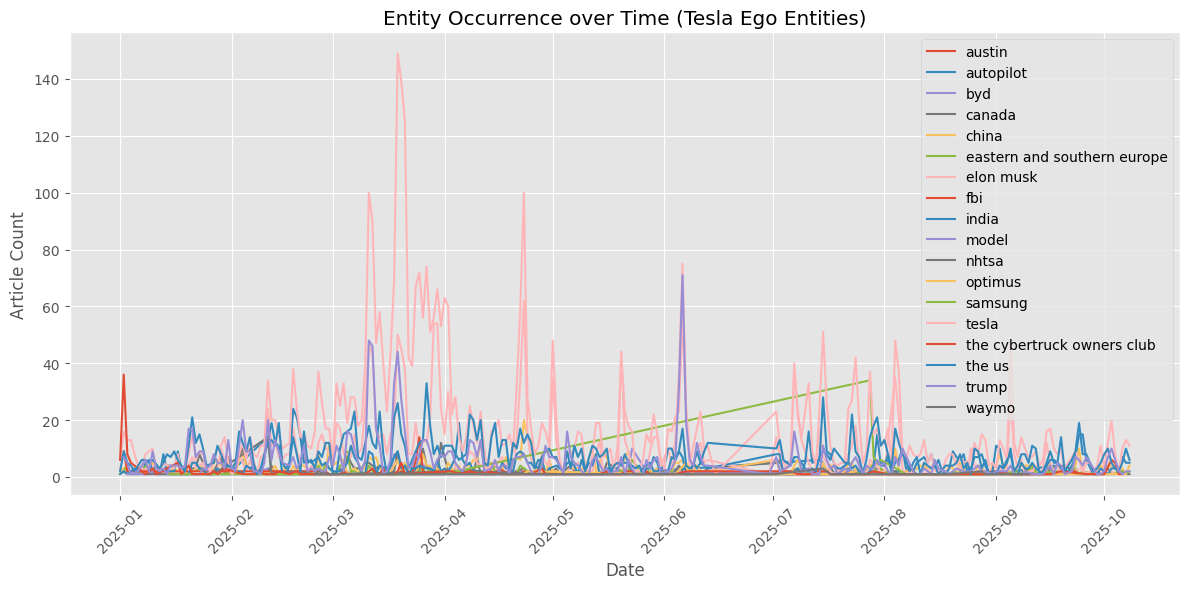

In [ ]:
# 13. Entity Frequency Over Time (Tesla ego network)

# The mentions dataframe used earlier for pair construction is used as the starting point.
# df_mentions has at least columns: SQLDATE, entity, TEXT_FILE
entity_df = df_mentions[["SQLDATE", "entity", "TEXT_FILE"]].dropna().copy()

# If SQLDATE is not already in datetime format, it is converted from numeric YYYYMMDD.
from pandas.api.types import is_datetime64_any_dtype

if not is_datetime64_any_dtype(entity_df["SQLDATE"]):
    entity_df["SQLDATE"] = pd.to_datetime(
        entity_df["SQLDATE"].astype("Int64").astype(str),
        format="%Y%m%d",
        errors="coerce",
    )

entity_df.dropna(subset=["SQLDATE"], inplace=True)

# Entity names are normalised (lower-cased and stripped) for grouping.
entity_df["entity_norm"] = (
    entity_df["entity"].astype(str).str.strip().str.lower()
)

# Tesla ego entities (all lower-cased) are specified.
tesla_ego_entities = [
    "tesla", "elon musk", "musk", "the us",
    "the cybertruck owners club", "model",
    "china", "trump", "eastern and southern europe",
    "canada", "autopilot", "waymo", "nhtsa", "optimus",
    "austin", "samsung", "india", "byd", "fbi",
]

# Only those ego entities are retained by filtering.
ego_df = entity_df[entity_df["entity_norm"].isin(tesla_ego_entities)].copy()
ego_df["date"] = ego_df["SQLDATE"].dt.date

# Occurrences per day per entity are counted.
daily_counts = (
    ego_df.groupby(["date", "entity_norm"])["TEXT_FILE"]
    .nunique()                         # or .count() may be used if raw mentions are preferred
    .reset_index(name="count")
)

# The time series for each ego entity is plotted.
plt.figure(figsize=(12, 6))
for ent, sub in daily_counts.groupby("entity_norm"):
    plt.plot(sub["date"], sub["count"], label=ent)

plt.title("Entity Occurrence over Time (Tesla Ego Entities)")
plt.xlabel("Date")
plt.ylabel("Article Count")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



## 14. N‑grams Analysis by Sentiment

N‑grams capture co‑occurring words that may reveal themes or topics in the articles.  This example shows how to
extract and plot unigrams, bigrams and trigrams from the processed text for each sentiment class.


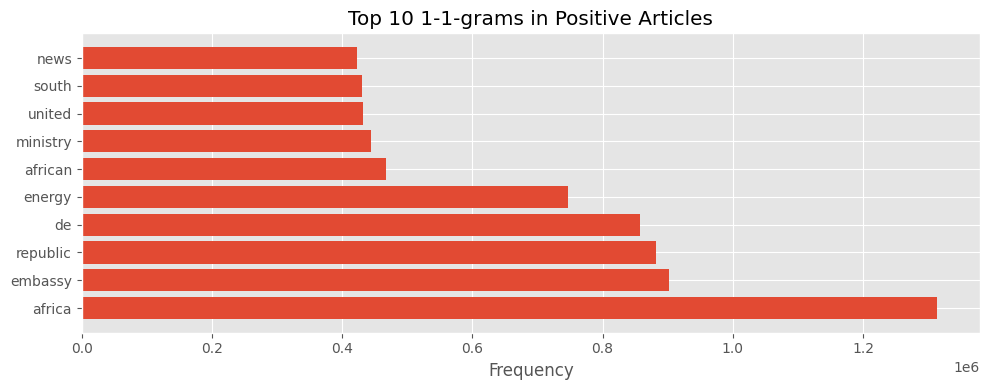

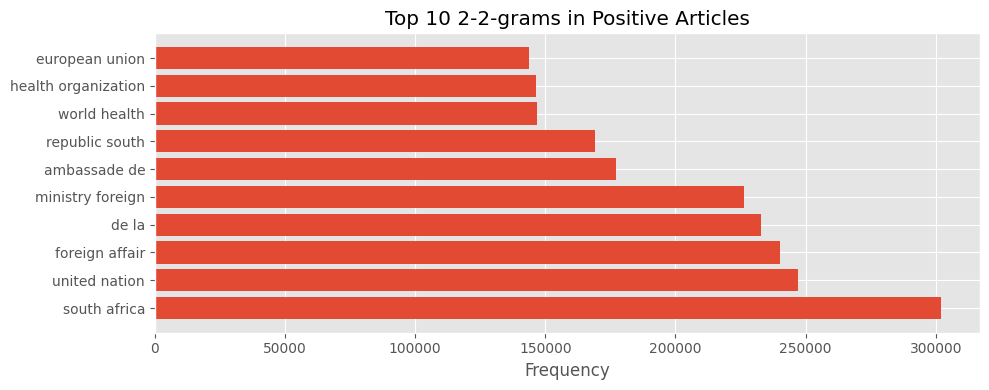

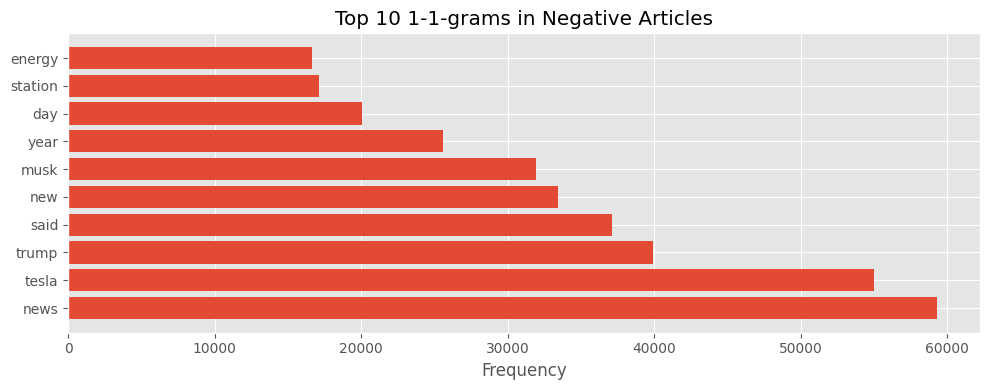

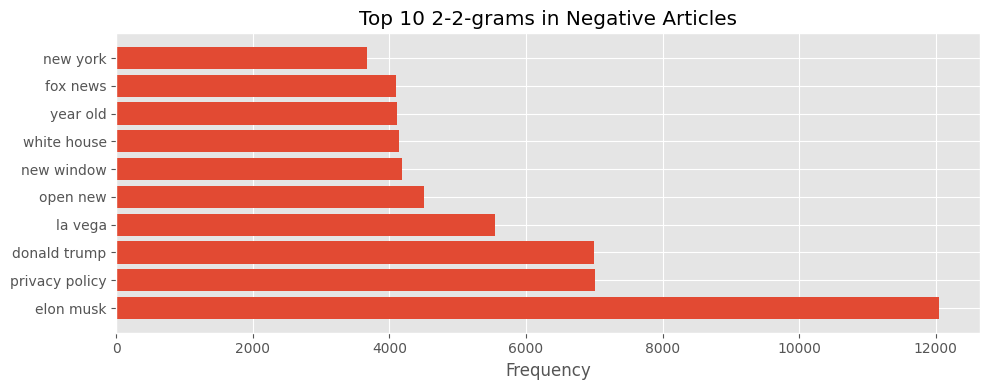

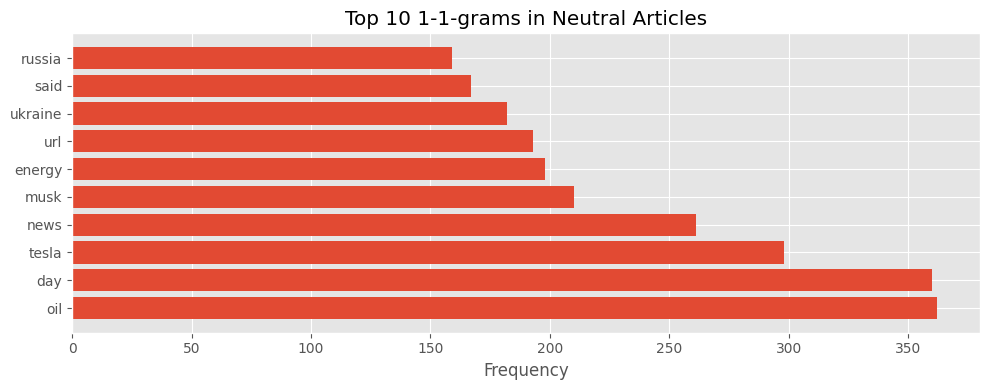

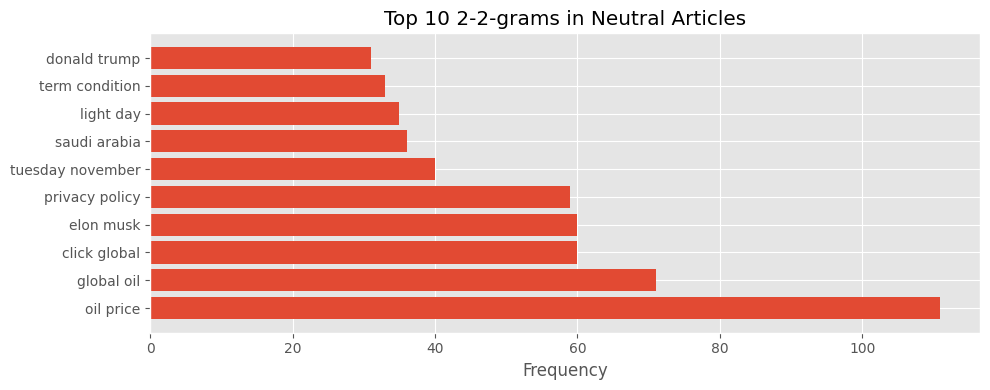

In [ ]:
## 14. N-grams Analysis by Sentiment

from sklearn.feature_extraction.text import CountVectorizer

def plot_top_ngrams(df, label, ngram_range=(1, 1), top_n=10):
    """
    The most frequent n-grams are plotted for articles with a given sentiment label.
    """
    # Rows with the specified sentiment label are selected.
    subset = df[df["sentiment_label"] == label]
    # Cleaned text values are extracted and converted to a list of strings.
    texts = subset["clean_text"].dropna().astype(str).tolist()
    if len(texts) == 0:
        print(f"No texts found for label '{label}'.")
        return

    # A CountVectorizer instance is created and fitted to the texts for the chosen n-gram range.
    vectorizer = CountVectorizer(ngram_range=ngram_range)
    X = vectorizer.fit_transform(texts)

    # Token counts and corresponding vocabulary entries are obtained.
    counts = np.asarray(X.sum(axis=0)).ravel()
    vocab  = np.array(vectorizer.get_feature_names_out())
    top_idx = counts.argsort()[::-1][:top_n]

    # The top n-grams and their frequencies are selected.
    top_ngrams = vocab[top_idx]
    top_counts = counts[top_idx]

    # A horizontal bar chart is plotted to display the most frequent n-grams.
    plt.figure(figsize=(10, 4))
    plt.barh(top_ngrams[::-1], top_counts[::-1])
    n1, n2 = ngram_range
    plt.title(f"Top {top_n} {n1}-{n2}-grams in {label} Articles")
    plt.xlabel("Frequency")
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()


for label in ["Positive", "Negative", "Neutral"]:
    # Unigrams are plotted.
    plot_top_ngrams(articles_with_text, label, ngram_range=(1, 1), top_n=10)
    # Bigrams are plotted (optional – can be commented out if too many plots are produced).
    plot_top_ngrams(articles_with_text, label, ngram_range=(2, 2), top_n=10)



## 15. Topic Modelling with BERTopic

Applying topic modelling to the processed corpus using BERTopic.

Modelling 5000 documents with BERTopic...


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

,Topic,Count,Name,Representation,Representative_Docs
0,-1,1314,-1_news_energy_tesla_said,"[news, energy, tesla, said, trump, new, oil, c...",[url apo group africa newsroom press release m...
1,0,115,0_musk_tesla_elon_trump,"[musk, tesla, elon, trump, company, share, ceo...",[url elon musk potential conflict interest tes...
2,1,101,1_climate_energy_american_trump,"[climate, energy, american, trump, said, polic...",[url trading energy scarcity agenda energy abu...
3,2,91,2_storage_battery_manufacturer_solar,"[storage, battery, manufacturer, solar, bess, ...",[url powin financial challenge reflective indu...
4,3,75,3_solar_energy_october_eskom,"[solar, energy, october, eskom, project, elect...",[url egypt renewable energy project new framew...
5,4,74,4_tesla_march_fire_reply,"[tesla, march, fire, reply, vehicle, attack, c...",[url violent attack tesla dealership spike mus...
6,5,73,5_tesla_cybertruck_car_model,"[tesla, cybertruck, car, model, truck, owner, ...",[url sign pure panic tesla resorted financing ...
7,6,69,6_musk_price_share_tesla,"[musk, price, share, tesla, elon, trump, calcu...",[url musk doge gig trump bleeds dry tesla offe...
8,7,67,7_pedia_ng_current_production,"[pedia, ng, current, production, company, ener...",[url tullow oil announces january trading stat...
9,8,67,8_ukraine_russia_putin_ukrainian,"[ukraine, russia, putin, ukrainian, ceasefire,...",[url ukraine update trump putin agree day ener...


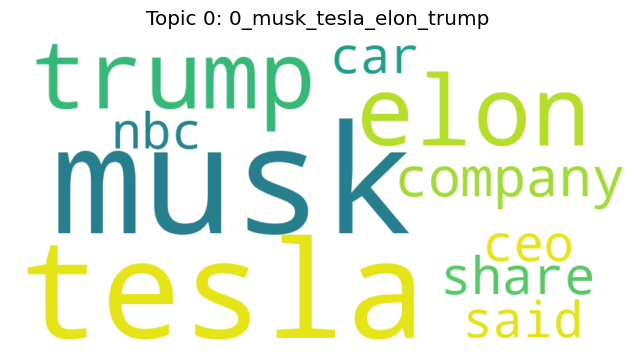

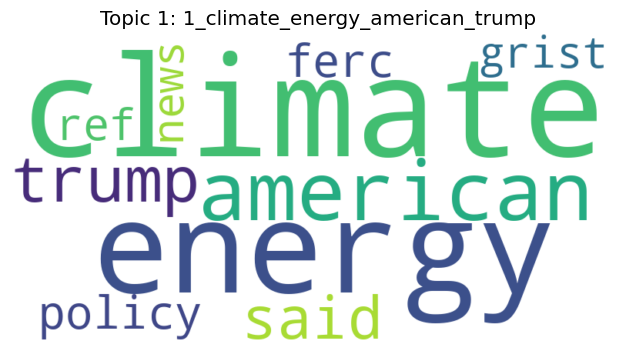

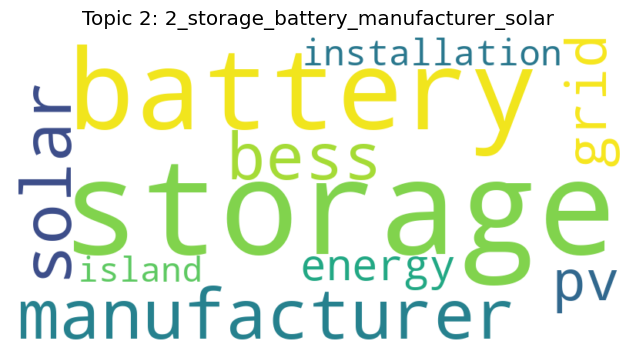

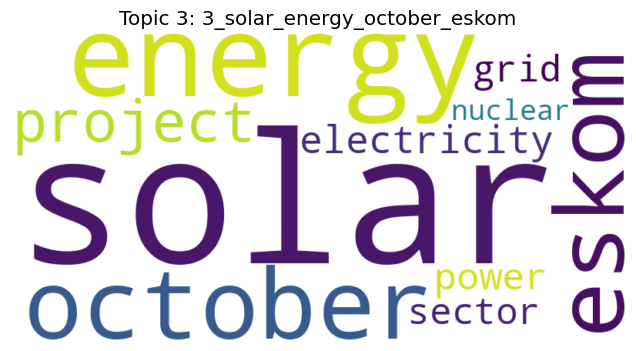

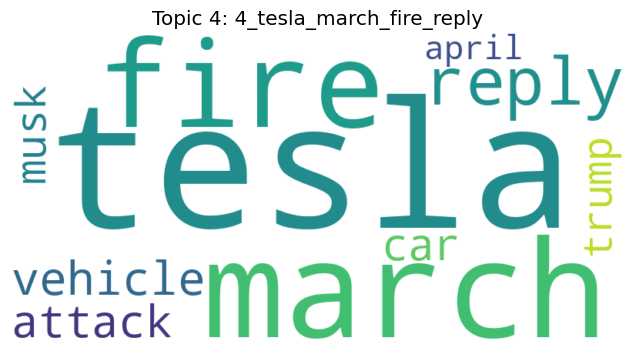

Saved BERTopic outputs to:
   /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/bertopic_topics.npy
   /content/drive/MyDrive/Colab Notebooks/NLP/NLP Project Shared/bertopic_probabilities.npy


In [ ]:
from bertopic import BERTopic
from wordcloud import WordCloud
import matplotlib.pyplot as plt
import numpy as np

# 15. Topic Modelling with BERTopic (on cleaned text)

# The full corpus is defined.
full_corpus = articles_with_text["clean_text"].tolist()
full_dates  = pd.to_datetime(articles_with_text["SQLDATE"])

# --- Subsampling is performed to increase speed (recommended for Colab) ---
max_docs = 5000
if len(full_corpus) > max_docs:
    rng = np.random.RandomState(42)
    sample_idx = rng.choice(len(full_corpus), size=max_docs, replace=False)
    processed_corpus = [full_corpus[i] for i in sample_idx]
    docs_dates       = full_dates.iloc[sample_idx].reset_index(drop=True)
else:
    processed_corpus = full_corpus
    docs_dates       = full_dates.reset_index(drop=True)

print(f"Modelling {len(processed_corpus)} documents with BERTopic...")

# ---- BERTopic is fitted (this remains the heavy step) ----
topic_model = BERTopic()
topics, probabilities = topic_model.fit_transform(processed_corpus)

# ---- Discovered topics are inspected ----
topic_info = topic_model.get_topic_info()
display(topic_info.head(10))

# ------------------------------------------------------------------
# 1) A global 2-D topic map is visualized (useful for the “shape” of the topic space)
# ------------------------------------------------------------------
fig_topics = topic_model.visualize_topics()
fig_topics.show()

# ------------------------------------------------------------------
# 2) An interactive bar-chart of the most important topics is displayed
# ------------------------------------------------------------------
fig_barchart = topic_model.visualize_barchart(top_n_topics=10)
fig_barchart.show()

# ------------------------------------------------------------------
# 3) Word-clouds are generated for the top K topics (used as an intuitive summary)
# ------------------------------------------------------------------
# The outlier topic -1 is removed and the next K topics are selected.
topic_info_no_outlier = topic_info[topic_info["Topic"] >= 0]
top_k = 5
top_topic_ids = topic_info_no_outlier["Topic"].head(top_k).tolist()

for t_id in top_topic_ids:
    # A list of (word, score) pairs is returned by topic_model.get_topic for each topic.
    words_scores = topic_model.get_topic(t_id)
    if not words_scores:
        continue

    freqs = {w: float(score) for w, score in words_scores}
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white"
    ).generate_from_frequencies(freqs)

    plt.figure(figsize=(8, 4))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    topic_label = topic_info_no_outlier.loc[
        topic_info_no_outlier["Topic"] == t_id, "Name"
    ].iloc[0]
    plt.title(f"Topic {t_id}: {topic_label}")
    plt.show()

# ------------------------------------------------------------------
# 4) Numeric outputs are saved for later reuse
# ------------------------------------------------------------------
topics_path = BASE_DIR / "bertopic_topics.npy"
probs_path  = BASE_DIR / "bertopic_probabilities.npy"

np.save(topics_path, np.array(topics))
np.save(probs_path, probabilities)
print("Saved BERTopic outputs to:")
print("  ", topics_path)
print("  ", probs_path)


In [ ]:
# #If we only want BERTopic for Tesla-related articles, we can first subset:
# tesla_mask = articles_with_text["text"].str.contains("tesla", case=False, na=False)
# corpus_tesla = articles_with_text.loc[tesla_mask, "clean_text"].tolist()
# dates_tesla  = pd.to_datetime(articles_with_text.loc[tesla_mask, "SQLDATE"]).tolist()
##then feed corpus_tesla and dates_tesla into BERTopic instead.